### Laurent Jutras-Dubé

## The gene-free models: asymmetric patterns

####    


**1. Pattern formation with the asymmetric gene-free models**

In this notebook, we perform deterministic simulations of the gene-free models. We introduce asymmetries in the fixed points of the static term, which leads to the formation of an asymmetric spatial pattern. See the Methods and Supplement for a description of the models.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'figure.max_open_warning': 0})

####    

**1.1 The ODEs**

In the following code cell, we define functions for the dynamic, static and intermediate modules, and a total derivative function that includes these modules and parameter $g$. We make sure that we can modify the positions of the fixed points of the static term, via parameter `usntable_fp`, `stale_fp1` and `stable_fp2`. We specify the values of all parameters in a dictionary in another code cell.

In [2]:
def dynamic(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    r = np.sqrt(y*y +z*z)
       
    dy = y*(1.-r) -z
    dz = z*(1.-r) +y
    
    return np.array([dy, dz]).transpose()



def static(conc, param):
    
    y = conc[:,0]
    z = conc[:,1]
    
    fp0 = param["unstable_fp"]
    fp1 = param["stable_fp1"]
    fp2 = param["stable_fp2"]
        
    dy = (fp0-y)*(fp1-y)*(fp2-y)
    dz = -z
    
    return np.array([dy, dz]).transpose()



def dvec(g, vec, param):
    
    if_interm = param["if_interm"]
    ng = param["ng"]    
    g = np.array([g, g]).transpose()
    
    return g**ng *dynamic(vec) +(1.-g)**ng *static(vec, param) -if_interm*g*(1.-g)*vec

####    

**1.2 The spatio-temporal profile of parameter _g_**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed, we make $t^*(x)$ a linear function of $x$, via the `positions` vector and the `v` parameter. In other words, we model a gradient of $g$ with a fixed steepness that moves in the posterior direction at a constant rate. We generate a kymograph showing the spatio-temporal profile of $g$ later in this notebook.

In [3]:
def compute_g(t, param):
    
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The integration scheme**

We use the Euler integration scheme to perform the integration of the ODEs describing the dynamics of variables $y$ and $z$. The `integrate` function requires two inputs: the initial values of the two variables at all spatial positions, and the dictionary of parameters. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasing this parameter can help reduce the size of the 3 output matrices, `results`, `g_gradient` and `times_plot`. These matrices contain respectively the values of the variables at all positions for every time point, the spatio-temporal distribution of parameter $g$ and the array of times.

In [4]:
def integrate(init_vec, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]

    vec = init_vec
    results = [vec]
    g = compute_g(0., param)
    g_gradient = [g]
   
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]

    
    # Perform the integration
    for t in times[1:]:
      
        vec = vec +dvec(g, vec, param)*dt
        g = compute_g(t, param)
    
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(vec)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

####  

**1.4 The kymograph plots**

We visualize the results of the integration with a kymograph where the horizontal axis is time and the vertical axis is the position of the cell along the tissue. On this kymograph, we represent the value of the $y$ component with a color gradient. We do not represent the $z$ component since it is always equal to 0 in the spatial pattern, and therefore does not provide any positional information.

We plot lines representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely 0.5 and 0.2. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

We also define a function that plots the spatial profile of variable $y$ at the time indexed by parameter `t_index`. We make two plots: a 1D profile and a schematic 2D profile.

In [5]:
def compute_x(g, t, param):

    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s +v*t



def compute_t(g, x, param):

    s = param["s"]
    v = param["v"]
    
    return (x -np.log(g)/s)/v
    

    
def plot_kymograph(results, g_gradient, times_plot, param):
    
    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()
    
    # Kymograph
    norm = colors.Normalize(vmin=param["colorbar_min"], vmax=param["colorbar_max"])
    kymo = ax.imshow(results[:,:,0].transpose(), norm=norm, cmap='Blues', aspect='auto')
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-2., -1, 0., 1., 2.])
    cb.ax.tick_params(labelsize=24)
    
    # Lines of constant g
    ax.plot(param["n_cells"]*compute_x(1., times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.1, param)/param["dt"], param["n_cells"]*0.1, '$g=1$', color='k', rotation=-70, fontsize=24)
    ax.text(compute_t(0.5, 0.1, param)/param["dt"], param["n_cells"]*0.1, '$g=0.5$', color='k', rotation=-70, fontsize=24)
    ax.text(compute_t(0.2, 0.1, param)/param["dt"], param["n_cells"]*0.1, '$g=0.2$', color='k', rotation=-70, fontsize=24)
    
    # Other plot options
    if (param["if_interm"] == 1.):    version = '1'
    else:    version = '2'
    
    ax.set_title('Model '+version+'       $y(x,t)$', fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()
    
    
    
def plot_y_profile(results, t_index, x_start, x_end, param):
    
    n_cells = param["n_cells"]
    positions = np.linspace(0.0, 1.0, n_cells)
    start = int(x_start*n_cells)
    end = int(x_end*n_cells)

    
    # Plot the 1D profile
    plt.rcParams["figure.figsize"] = 6.4, 3.
    fig, ax = plt.subplots()

    # y profile
    ax.plot(positions[start:end], results[t_index,start:end,0], c='tab:blue', lw=4, label='$y$', zorder=10)

    # Plot options
    ax.set_xlabel('$x$', fontsize=32)
    ax.set_ylabel('$y$', fontsize=32)
    ax.set_xlim([positions[start], positions[end]])
    ax.set_xticks([])
    ax.tick_params(labelsize=24)
    ax.set_ylim([-1.05, 1.05])

    fig.tight_layout()
    fig.show()
    
    
    # Plot the schematic 2D profile
    fig, ax = plt.subplots()
    tissue = np.array([results[t_index,start:end,0] for k in range(param["tissue_width"])])
    
    norm = colors.Normalize(vmin=param["colorbar_min"], vmax=param["colorbar_max"])
    ax.imshow(tissue, norm=norm, cmap='Blues', aspect='auto')  
    
    ax.axis('off')
    fig.show()

####  

**1.5 The dynamics of pattern formation in asymmetric 2D model**

We define all the required parameters for the ODEs, the gradient of parameter $g$ and the integration. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. In Model 1, we set `ng` to 3 and `if_interm` to 1, while in Model 2 we set `ng` to 1 and `if_interm` to 0.

In [6]:
param ={
    
    # ODEs parameter
    "unstable_fp" : 0.,
    "stable_fp1"  : 1.,
    "stable_fp2"  : -1.,
    "if_interm"   : 0.,
    "ng"          : 1,
    
    # Morphogen gradient parameters
    "s"       : 1.,
    "v"       : 0.036,
    "n_cells" : 1000,
    
    # Integration parameters
    "total_t"                : 80.,
    "dt"                     : 0.01,
    "n_steps_keep_results"   : 1,
    "tissue_width" : 50,
    
    # Parameters for the plots
    "colorbar_min" : -1.,
    "colorbar_max" : 1.
}


init_vec = np.zeros((param["n_cells"], 2))
init_vec[:,0] = 1.0

####    

**1.5.1 Symmetric basins of attraction**

We perform simulations with the stable fixed points of the static module at (-1, 0) and (1, 0), and the unstable fixed point at (0,0).

<IPython.core.display.Javascript object>


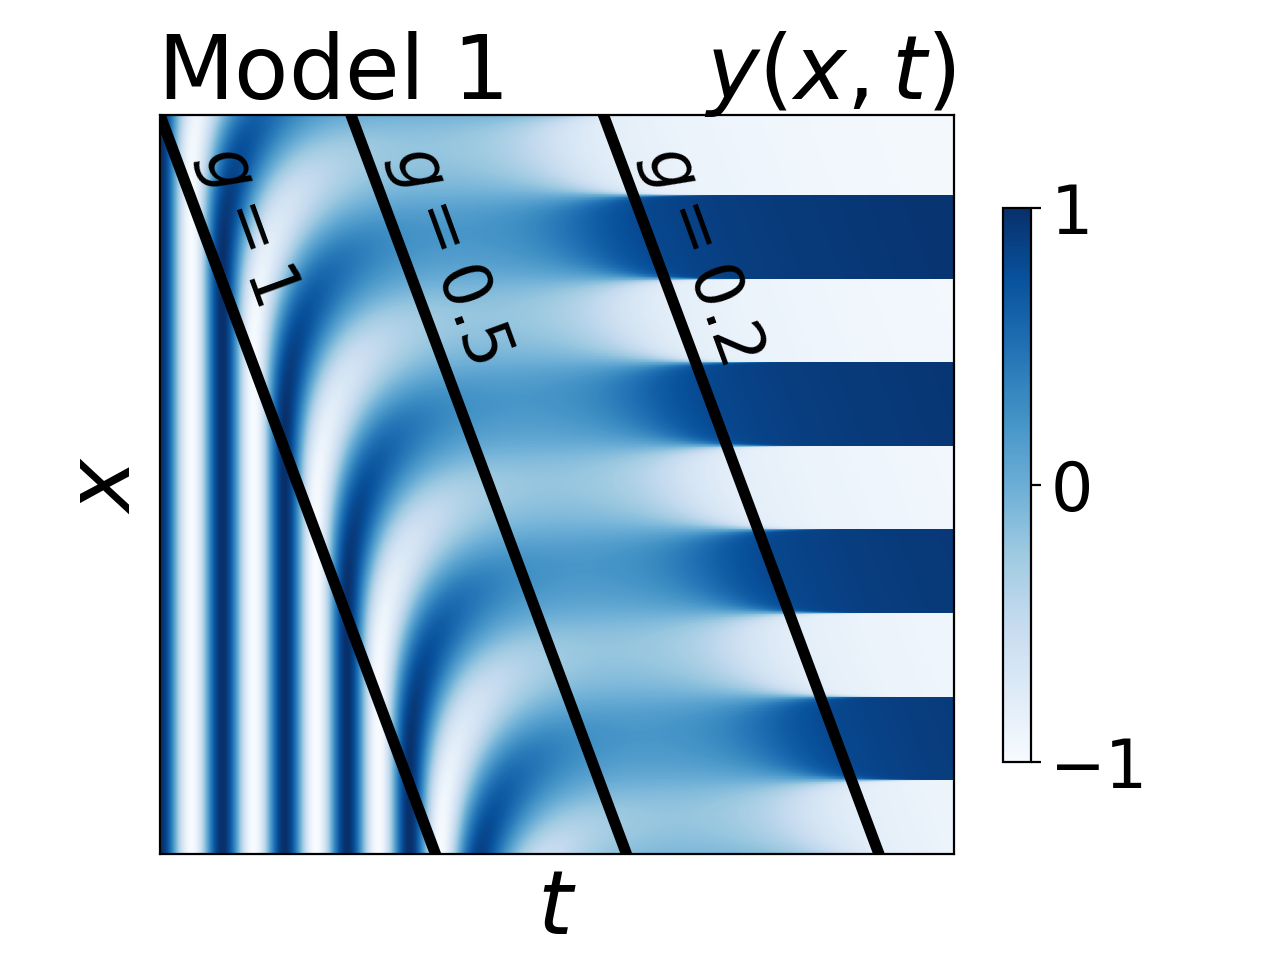

<IPython.core.display.Javascript object>


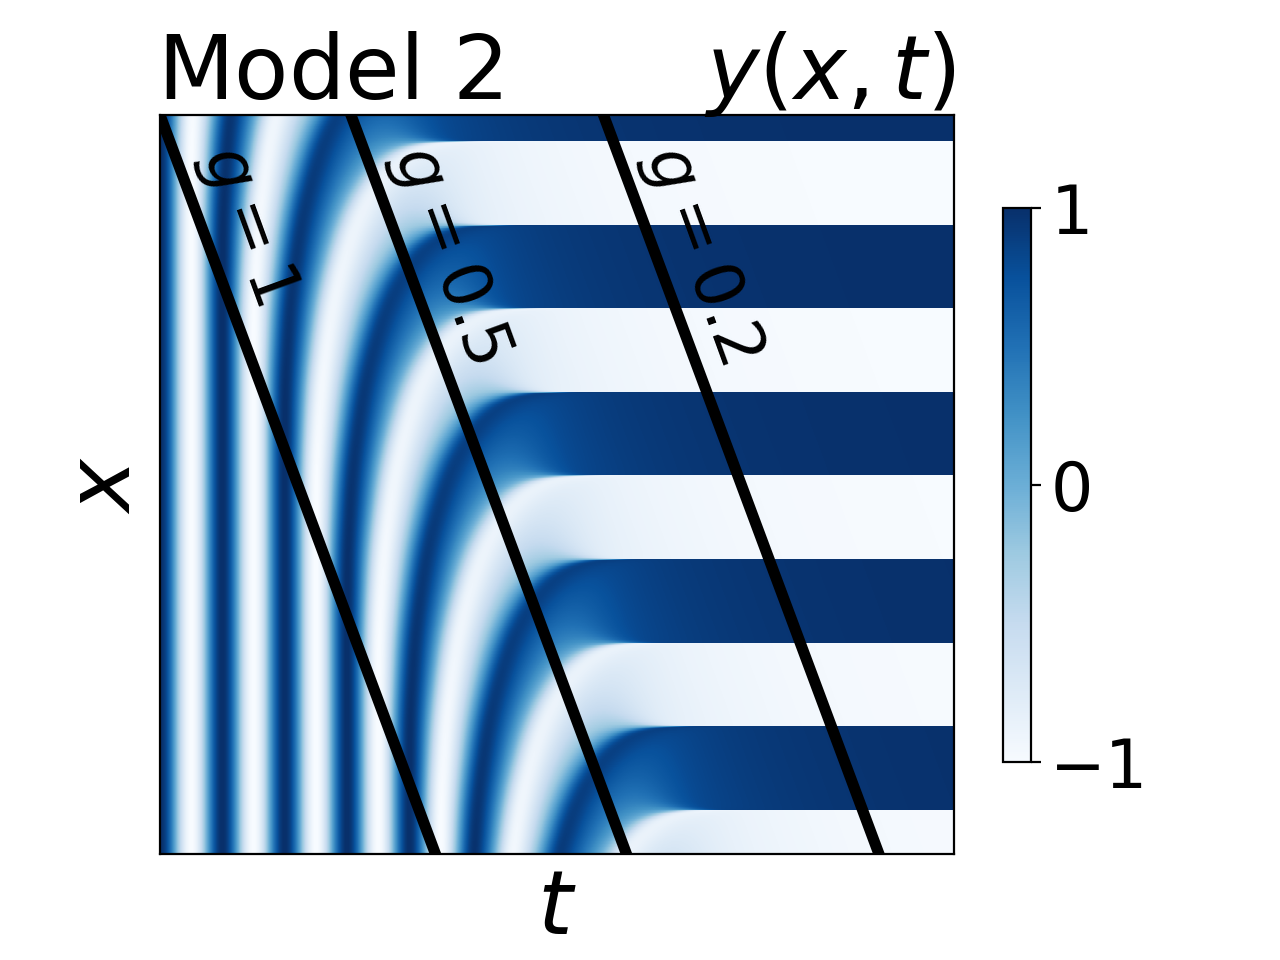

In [7]:
param["unstable_fp"] = 0.
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.


# Gene-free model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.

results_sym_m1, g_gradient_sym_m1, times_plot_sym_m1 = integrate(init_vec, param)
plot_kymograph(results_sym_m1, g_gradient_sym_m1, times_plot_sym_m1, param)


# Gene-free model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.

results_sym_m2, g_gradient_sym_m2, times_plot_sym_m2 = integrate(init_vec, param)
plot_kymograph(results_sym_m2, g_gradient_sym_m2, times_plot_sym_m2, param)

####    

**1.5.2 Slightly asymmetric basins of attraction**

We perform simulations with the stable fixed points of the static module at (-1, 0) and (1, 0), and the unstable fixed point at (0.05,0).

<IPython.core.display.Javascript object>


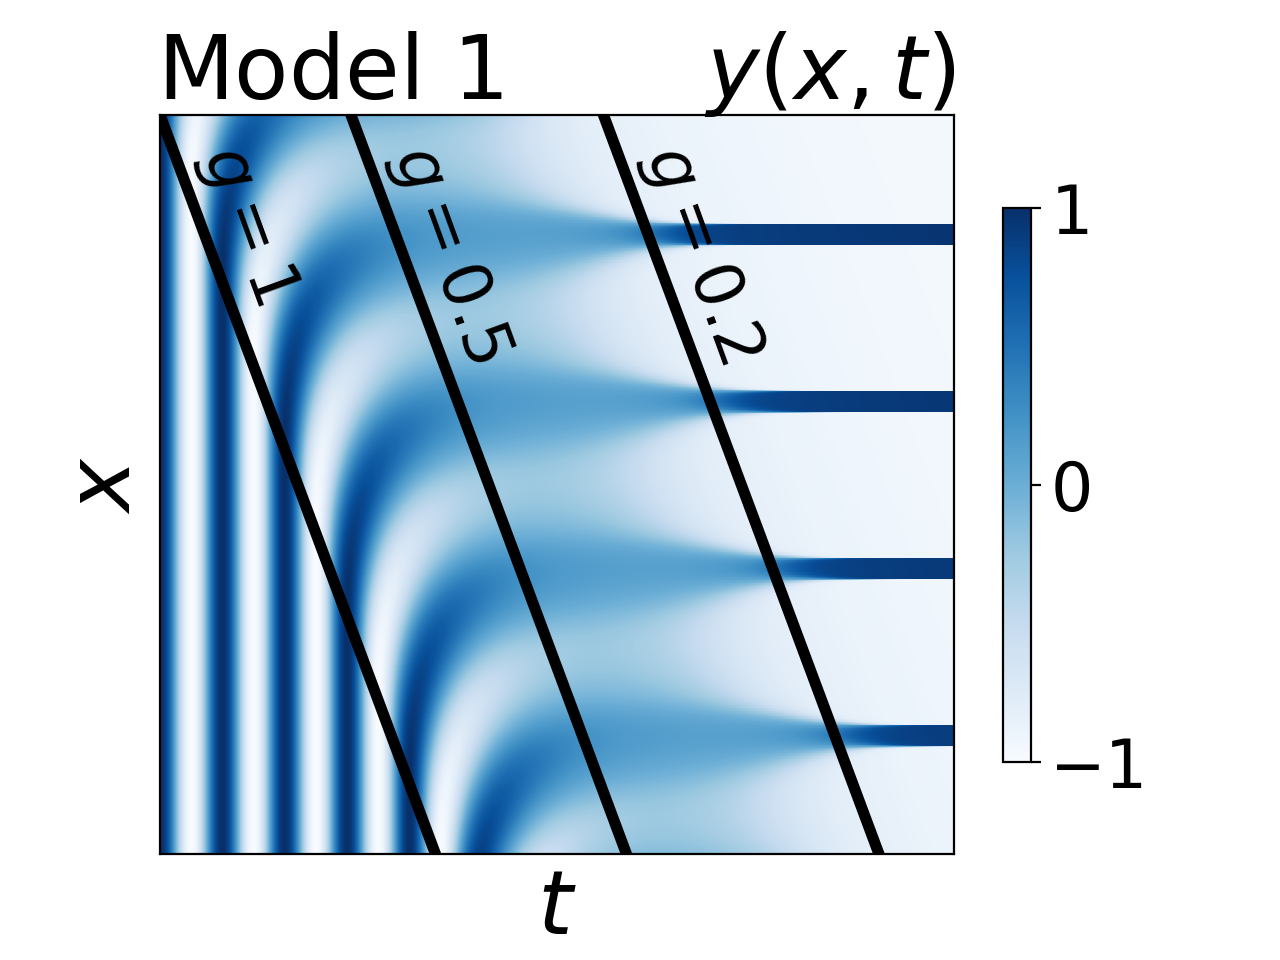

<IPython.core.display.Javascript object>


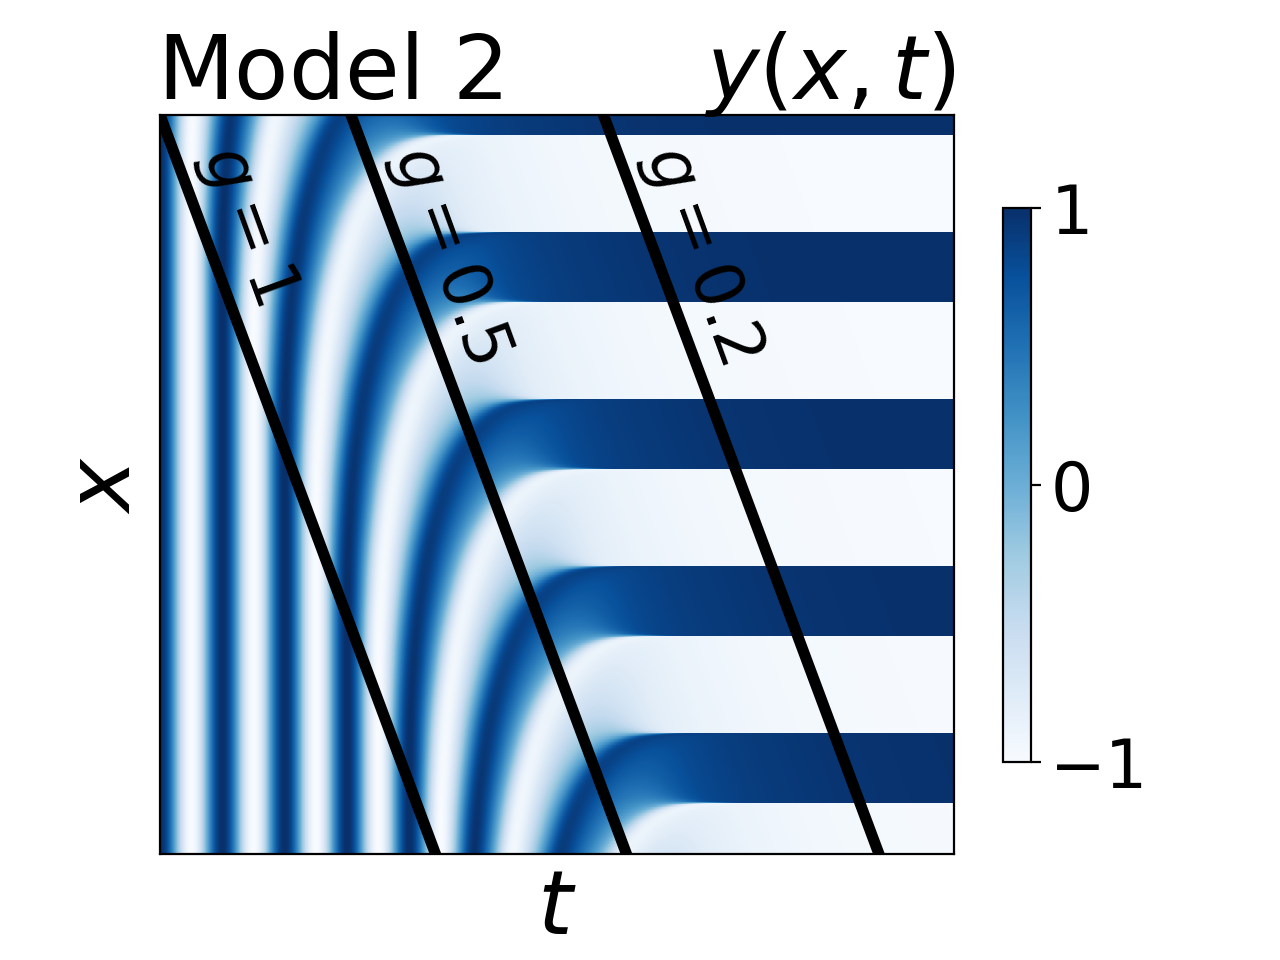

In [8]:
param["unstable_fp"] = 0.05
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.


# 2D model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.

results_asym1_m1, g_gradient_asym1_m1, times_plot_asym1_m1 = integrate(init_vec, param)
plot_kymograph(results_asym1_m1, g_gradient_asym1_m1, times_plot_asym1_m1, param)


# 2D model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.

results_asym1_m2, g_gradient_asym1_m2, times_plot_asym1_m2 = integrate(init_vec, param)
plot_kymograph(results_asym1_m2, g_gradient_asym1_m2, times_plot_asym1_m2, param)

####    

**1.5.3 Asymmetric basins of attraction**

We perform simulations with the stable fixed points of the static module at (-1, 0) and (1, 0), and the unstable fixed point at (0.1,0).

<IPython.core.display.Javascript object>


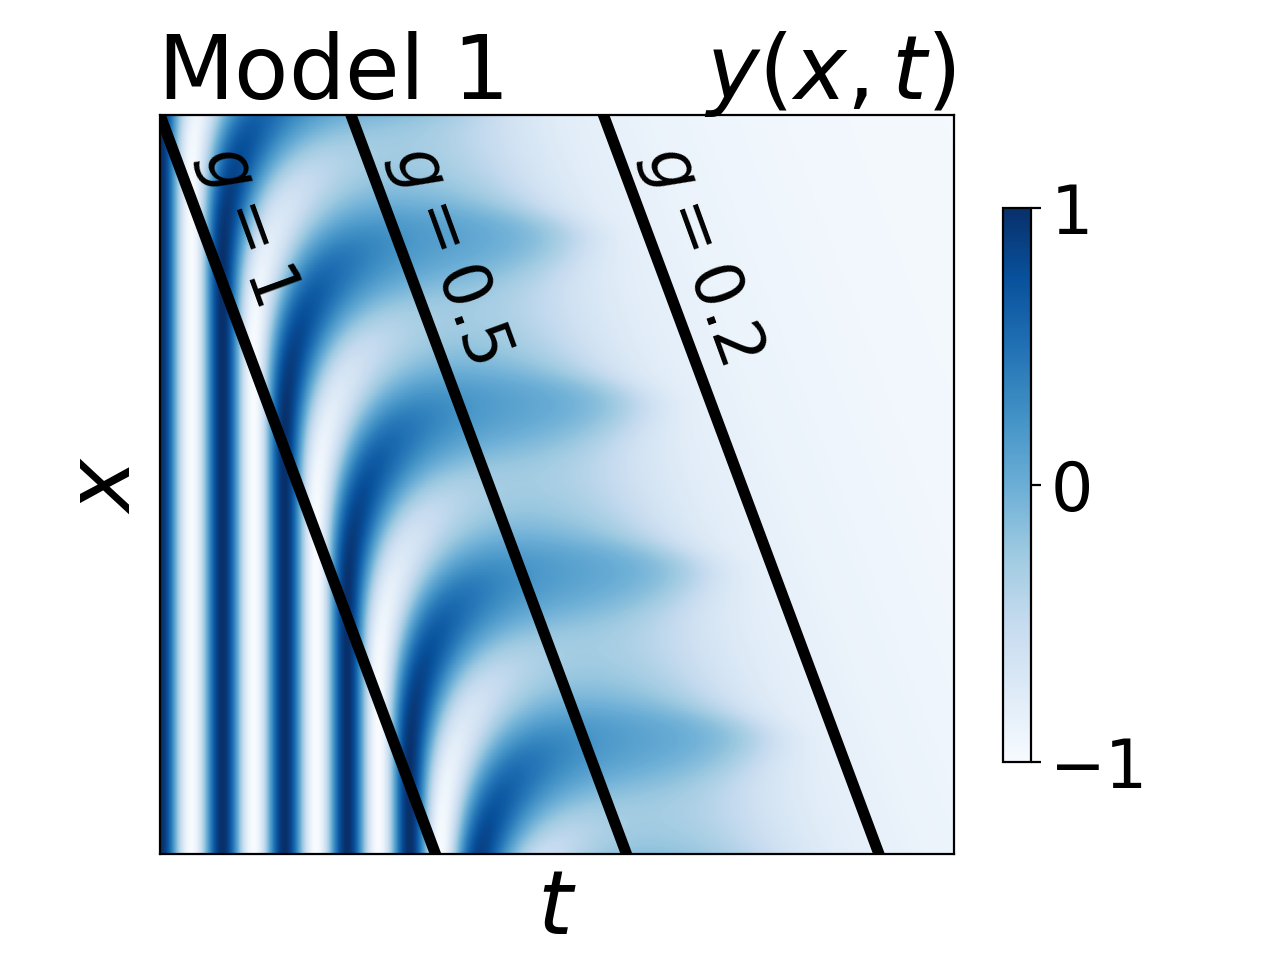

<IPython.core.display.Javascript object>


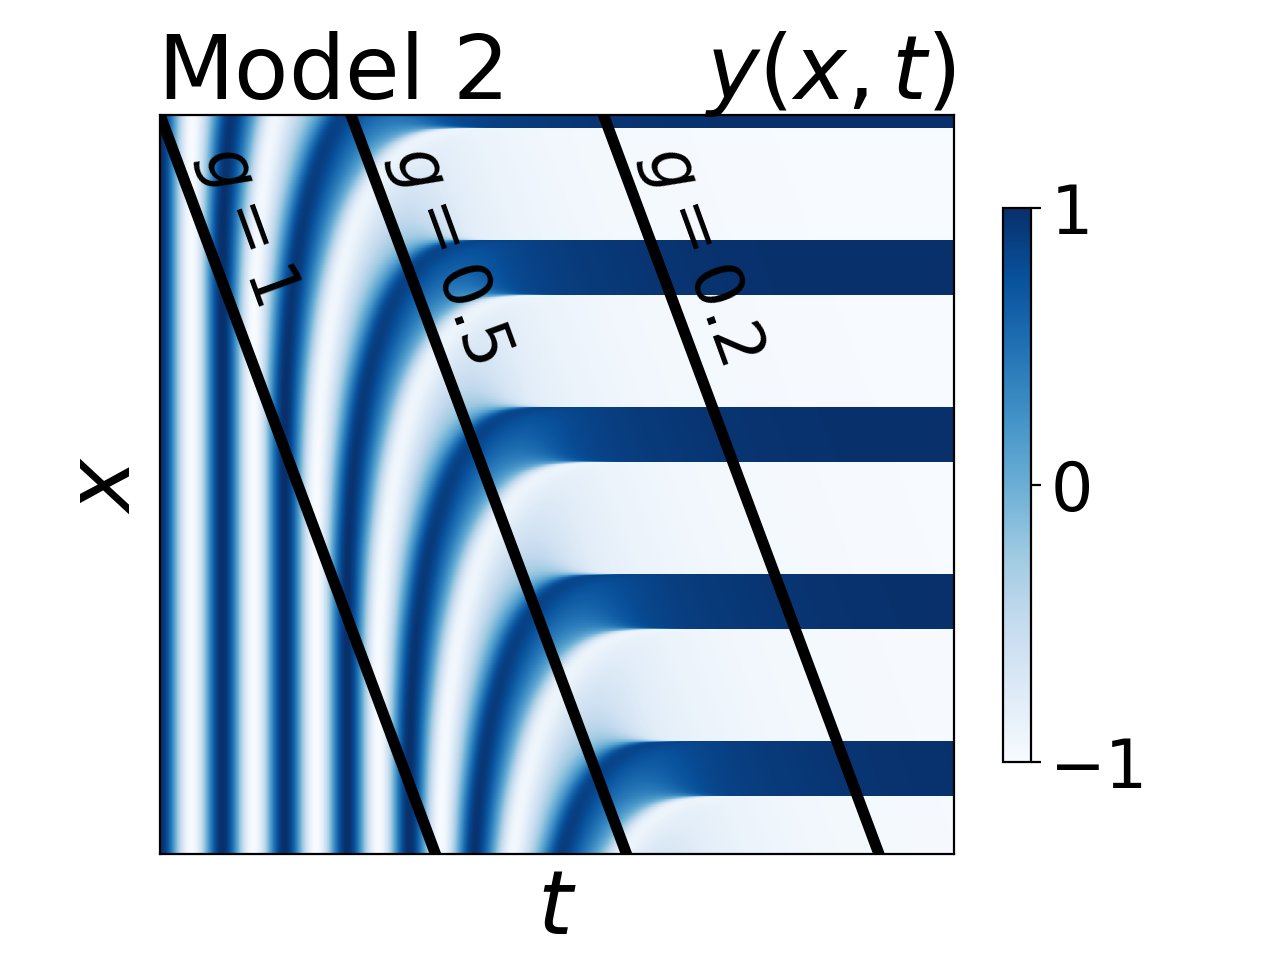

In [9]:
param["unstable_fp"] = 0.1
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.


# 2D model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.

results_asym2_m1, g_gradient_asym2_m1, times_plot_asym2_m1 = integrate(init_vec, param)
plot_kymograph(results_asym2_m1, g_gradient_asym2_m1, times_plot_asym2_m1, param)


# 2D model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.

results_asym2_m2, g_gradient_asym2_m2, times_plot_asym2_m2 = integrate(init_vec, param)
plot_kymograph(results_asym2_m2, g_gradient_asym2_m2, times_plot_asym2_m2, param)

####      

**1.5.4 Fixed points outside the limit cycle**

We perform simulations with the stable fixed points of the static module at (-2, 0) and (2.5, 0), and the unstable fixed point at (0,0).

<IPython.core.display.Javascript object>


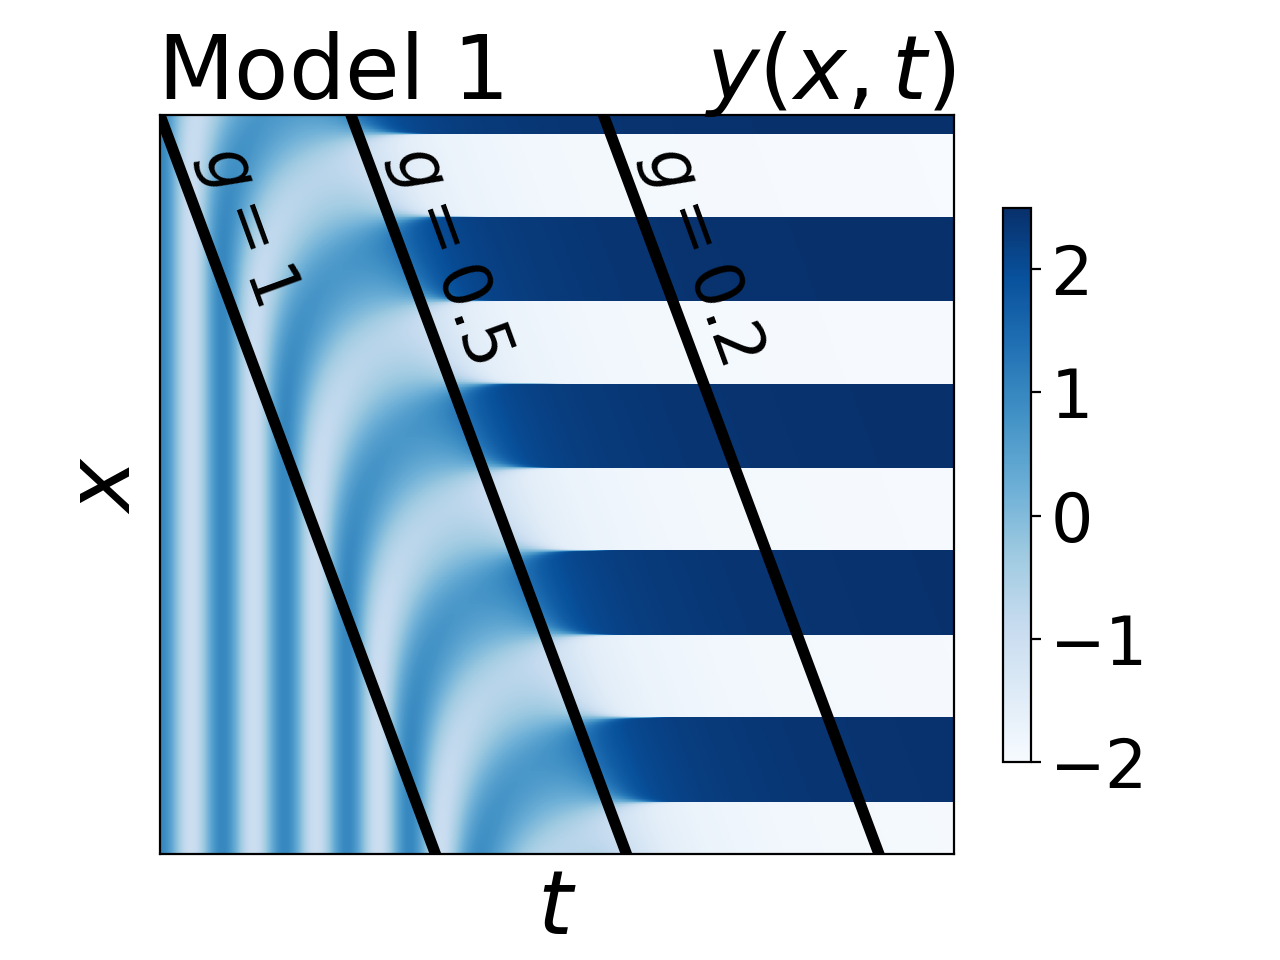

<IPython.core.display.Javascript object>


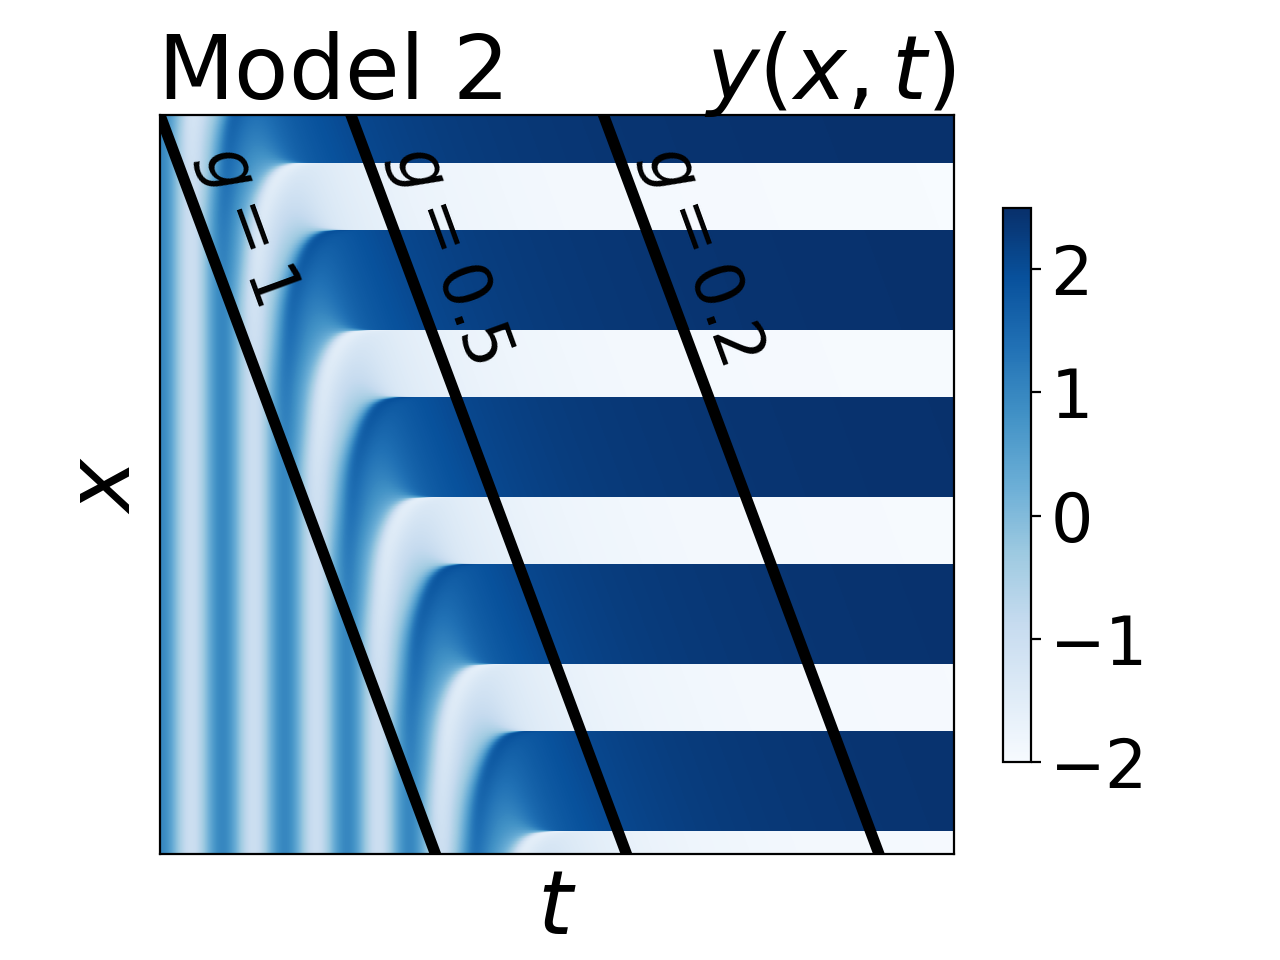

In [10]:
param["unstable_fp"] = 0.
param["stable_fp1"] = 2.5
param["stable_fp2"] = -2.
param["colorbar_max"] = 2.5
param["colorbar_min"] = -2.


# 2D model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.

results_asym3_m1, g_gradient_asym3_m1, times_plot_asym3_m1 = integrate(init_vec, param)
plot_kymograph(results_asym3_m1, g_gradient_asym3_m1, times_plot_asym3_m1, param)


# 2D model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.

results_asym3_m2, g_gradient_asym3_m2, times_plot_asym3_m2 = integrate(init_vec, param)
plot_kymograph(results_asym3_m2, g_gradient_asym3_m2, times_plot_asym3_m2, param)

####    

**1.5.4 Dynamics of parameter _g_**

In the next code cell, we generate a kymograph showing the spatio-temporal profile of $g$, and a plot of the spatial profile of $g$ at different time points in a given cell.

<IPython.core.display.Javascript object>


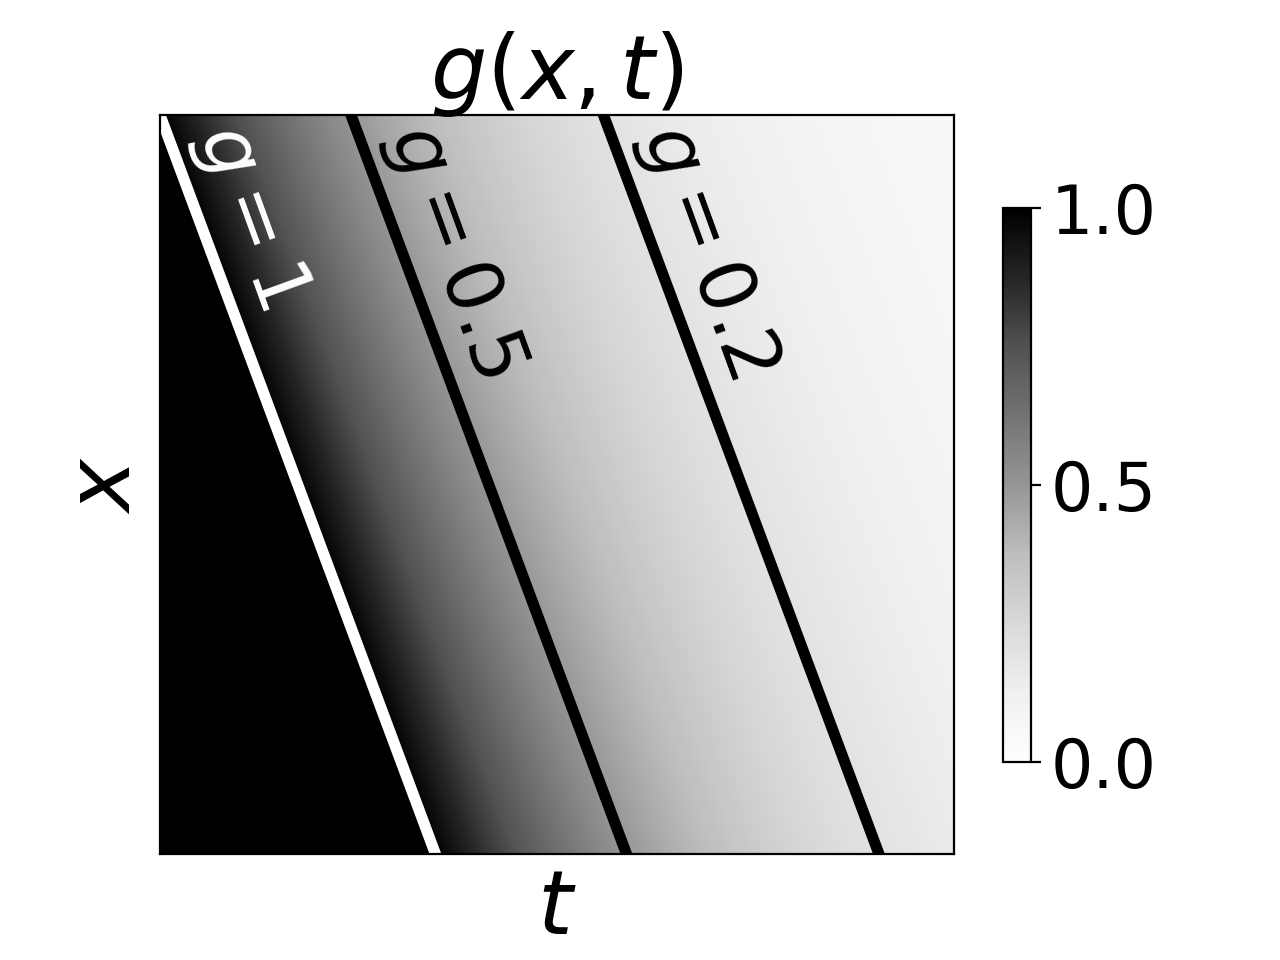

In [12]:
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_gradient_sym_m1.transpose(), norm=norm, cmap='Greys', aspect='auto')
    
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
    
ax.plot(param["n_cells"]*compute_x(1., times_plot_sym_m1, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times_plot_sym_m1, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times_plot_sym_m1, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.08, param)/param["dt"], param["n_cells"]*0.08, '$g=1$', color='w', rotation=-70, fontsize=28)
ax.text(compute_t(0.5, 0.08, param)/param["dt"], param["n_cells"]*0.08, '$g=0.5$', color='k', rotation=-70, fontsize=28)
ax.text(compute_t(0.2, 0.08, param)/param["dt"], param["n_cells"]*0.08, '$g=0.2$', color='k', rotation=-70, fontsize=28)
    
    
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####    

**2. Bifurcation diagrams**

For all versions of the gene-free model simulated above, we generate a bifurcation diagram that shows the position in phase space of the fixed points and limit cycles as a function of parameter $g$. We plot the values of $y$ at which stable and unstable fixed points can be found, as well as the minimum and maximum values of $y$ that are reached by the oscillations on the limit cycle. The XPP AUTO software was used to generate the data plotted on these bifurcation diagams. The `.dat` data files, as well as the `.ode` files used to generate the data can be found in the `XPP_AUTO_data` folder.


####   

**2.1 Extracting the fixed points and limit cycles**

We first define functions that extract the data obtained with the XPP AUTO software. The function `extract_fixed_pts` outputs a matrix containing information about the position of the fixed points in the data file and an array of colors for the fixed points, either green for a stable fixed point or red for an unstable fixed point. Similarly, the function `extract_limit_cycles` assigns a color to each limit cycle in the data file, either grey for a stable cycle or blue for an unstable cycle.

In [13]:
def extract_fixed_pts(data_file):
    
    fixed_pts = np.genfromtxt(data_file, delimiter=' ')

    fixed_pts_color = []
    for fps in fixed_pts[:,0]:
    
        if (int(fps) == 1):    fixed_pts_color.append('tab:green')
        elif (int(fps) == 2):    fixed_pts_color.append('tab:red')
        else:
            print('ERROR: one of the points is neither a stable nor unstable equilibria.')
            break
            
    return fixed_pts, fixed_pts_color

        

def extract_limit_cycles(data_file):
    
    limit_cycles = np.genfromtxt(data_file, delimiter=' ')

    limit_cycles_color = []
    for lc in limit_cycles[:,0]:
    
        if (int(lc) == 3):    limit_cycles_color.append('tab:grey')
        elif (int(lc) == 4):    limit_cycles_color.append('tab:blue')
        else:
            print('ERROR: one of the points is neither stable nor unstable periodics.')
            break
            
    return limit_cycles, limit_cycles_color

####   

**2.2 Generating the bifurcation diagrams**

We generate the bifurcation diagrams, and indicate the bifurcation events that occur in each model.


####    

**2.2.1 Symmetric basins of attraction**

We perform simulations with the stable fixed points of the static module at (-1, 0) and (1, 0), and the unstable fixed point at (0,0).

<IPython.core.display.Javascript object>


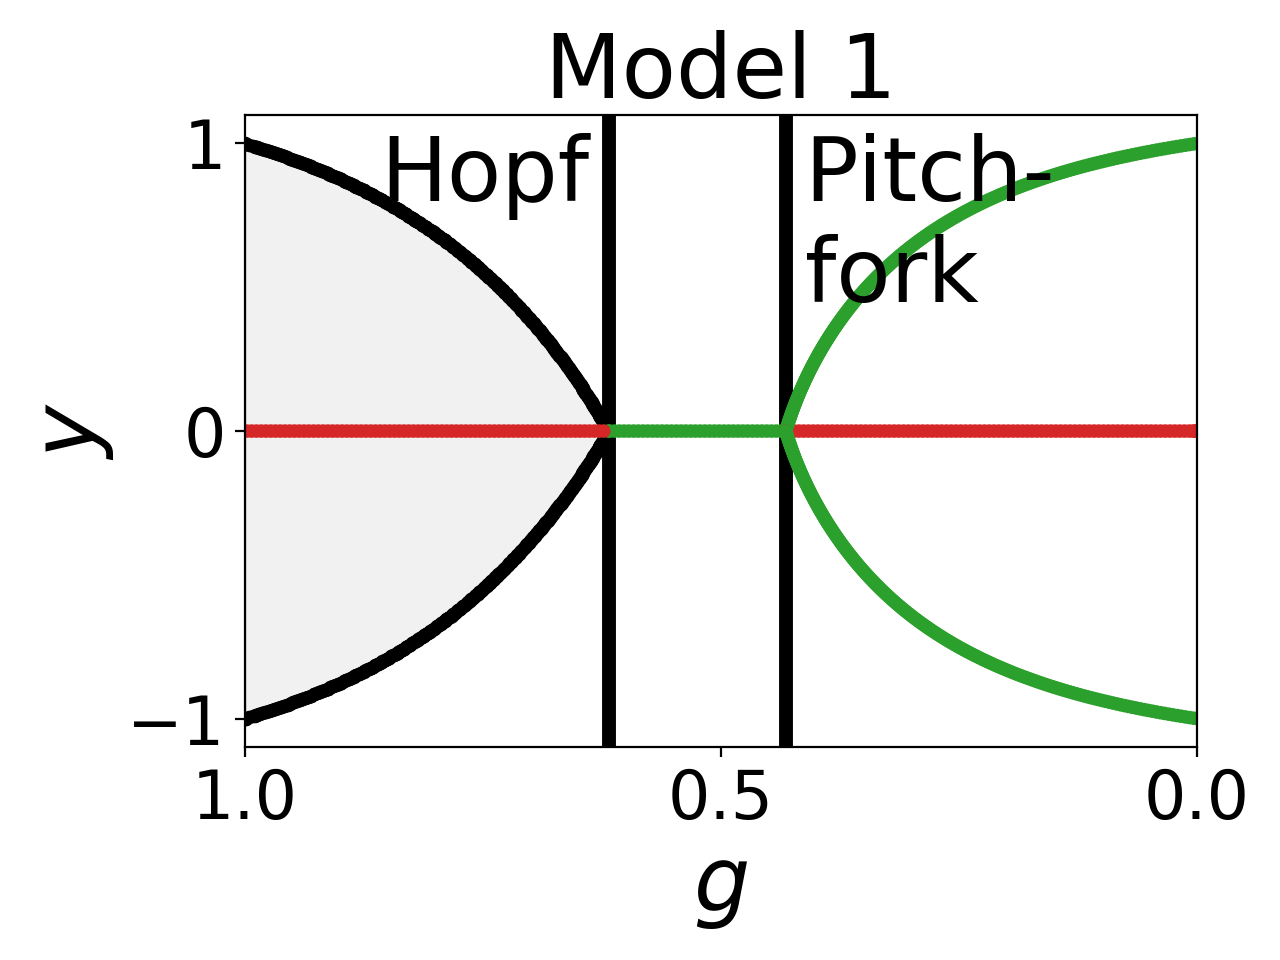

In [14]:
# 2D model with a Hopf bifurcation (Model 1)

# Extract the positions of the fixed points and limit cycles
fp_sym_m1, fp_sym_m1_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_m1_fp.dat')
lc_sym_m1, lc_sym_m1_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_m1_lc.dat')
g_Hopf = 0.618
g_pitchfork = 0.432


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_sym_m1[:210,3], lc_sym_m1[:210,6], lc_sym_m1[:210,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_sym_m1[:,3], lc_sym_m1[:,6], s=15, color='k')
ax.scatter(lc_sym_m1[:,3], lc_sym_m1[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_sym_m1[:,3], fp_sym_m1[:,6], s=15, color=fp_sym_m1_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-3.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.8, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_pitchfork, g_pitchfork], [-3.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_pitchfork-0.02, 0.8, 'Pitch-', fontsize=32, horizontalalignment='left')
ax.text(g_pitchfork-0.02, 0.45, 'fork', fontsize=32, horizontalalignment='left')

# Plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-1., 0., 1.])
              
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


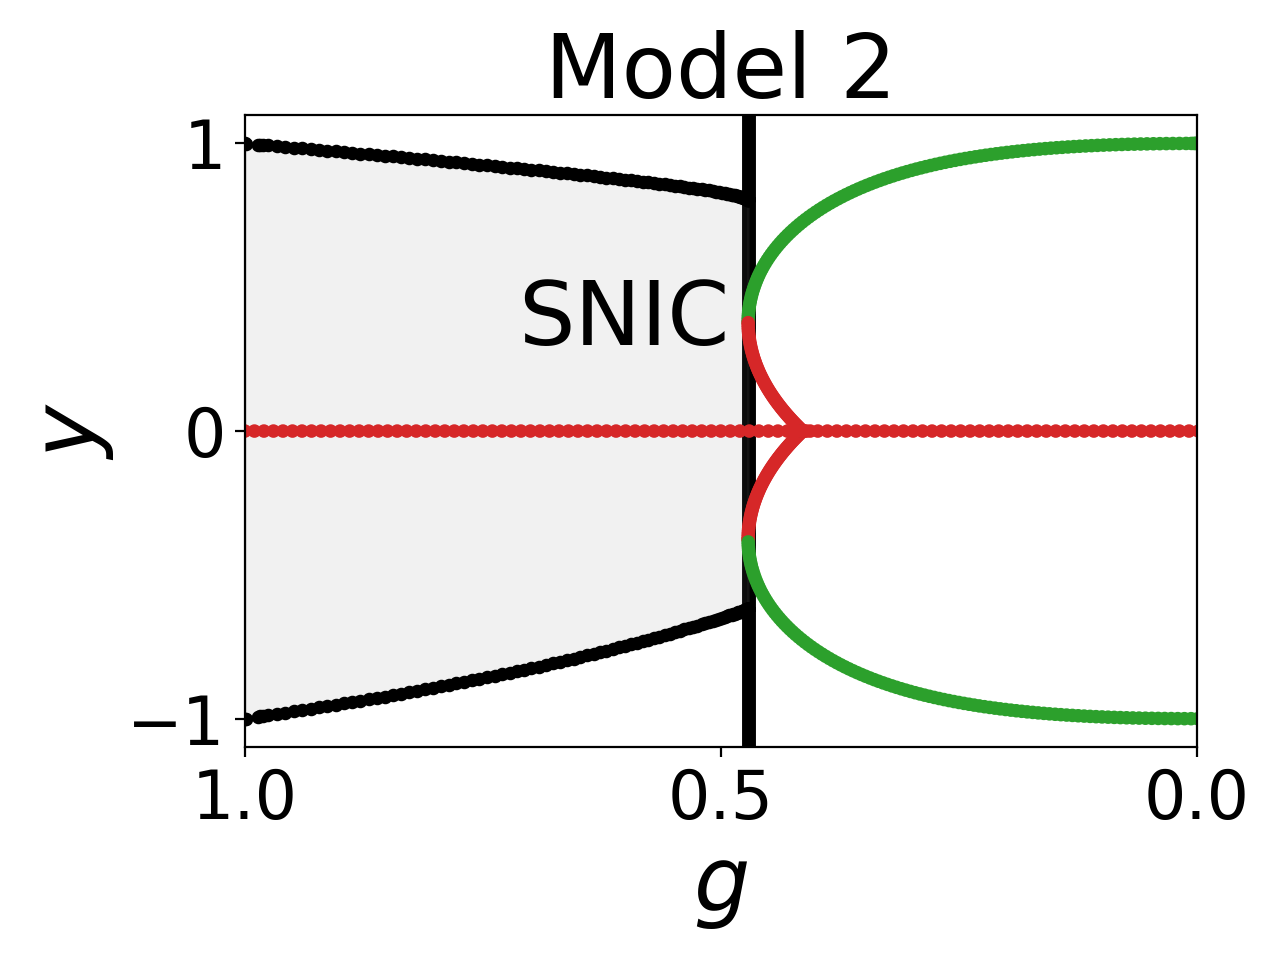

In [36]:
# 2D model with a SNIC bifurcation (Model 2)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_sym_m2, fp_sym_m2_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_m2_fp.dat')
lc_sym_m2, lc_sym_m2_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_m2_lc.dat')
g_SNIC = 0.471


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_sym_m2[:,3], lc_sym_m2[:,6], lc_sym_m2[:,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_sym_m2[:,3], lc_sym_m2[:,6], s=15, color='k')
ax.scatter(lc_sym_m2[:,3], lc_sym_m2[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_sym_m2[:,3], fp_sym_m2[:,6], s=15, color=fp_sym_m2_color)

# Bifurcation
ax.plot([g_SNIC, g_SNIC], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.3, 'SNIC', fontsize=32, horizontalalignment='right')

# Plot options
ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-1., 0., 1.])
        
fig.tight_layout()
fig.show()

####    

**2.2.2 Slightly asymmetric basins of attraction**

We perform simulations with the stable fixed points of the static module at (-1, 0) and (1, 0), and the unstable fixed point at (0.05,0).

<IPython.core.display.Javascript object>


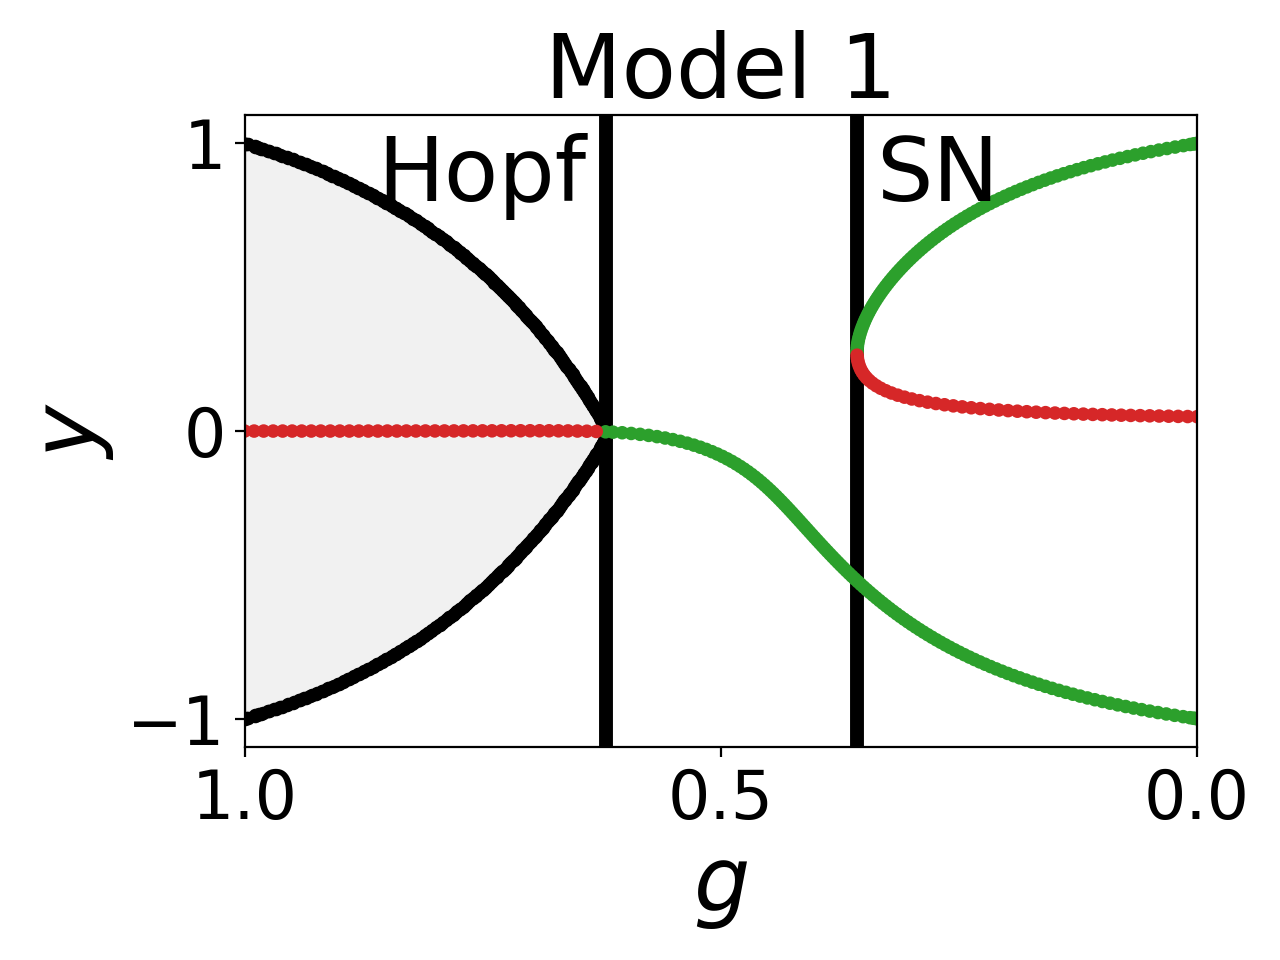

In [17]:
# 2D model with a Hopf bifurcation (Model 1)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_asym1_m1, fp_asym1_m1_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_asym1_m1_fp.dat')
lc_asym1_m1, lc_asym1_m1_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_asym1_m1_lc.dat')
g_Hopf = 0.621
g_SN = 0.357


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym1_m1[:110,3], lc_asym1_m1[:110,6], lc_asym1_m1[:110,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym1_m1[:,3], lc_asym1_m1[:,6], s=15, color='k')
ax.scatter(lc_asym1_m1[:,3], lc_asym1_m1[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_asym1_m1[:,3], fp_asym1_m1[:,6], s=15, color=fp_asym1_m1_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-3.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.8, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN, g_SN], [-3.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SN-0.02, 0.8, 'SN', fontsize=32, horizontalalignment='left')
    
# Plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-1., 0., 1.])
         
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


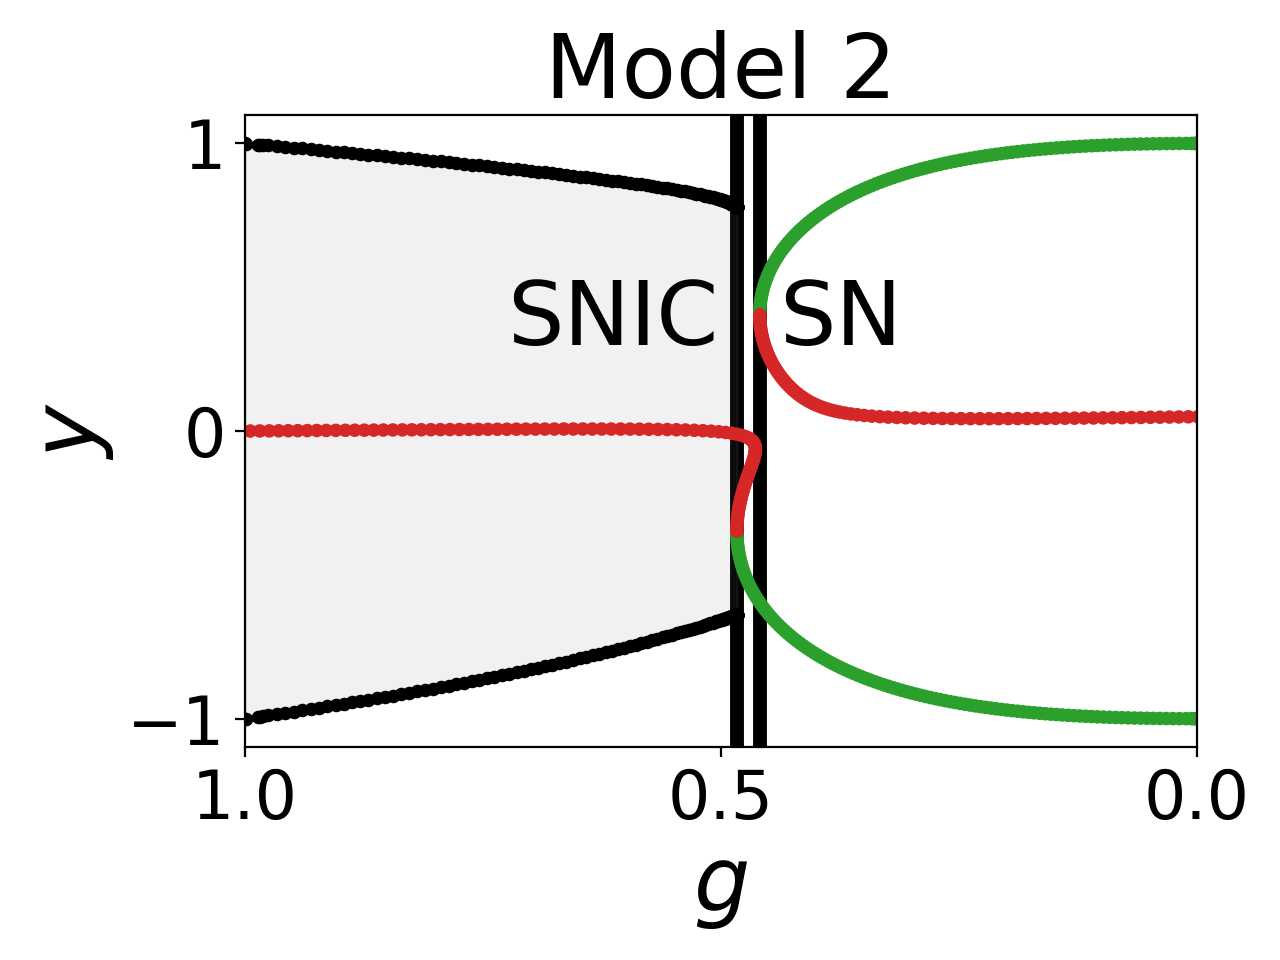

In [18]:
# 2D model with a SNIC bifurcation (Model 2)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_asym1_m2, fp_asym1_m2_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_asym1_m2_fp.dat')
lc_asym1_m2, lc_asym1_m2_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_asym1_m2_lc.dat')
g_SNIC = 0.483
g_SN = 0.459


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym1_m2[:,3], lc_asym1_m2[:,6], lc_asym1_m2[:,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym1_m2[:,3], lc_asym1_m2[:,6], s=15, color='k')
ax.scatter(lc_asym1_m2[:,3], lc_asym1_m2[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_asym1_m2[:,3], fp_asym1_m2[:,6], s=15, color=fp_asym1_m2_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.3, 'SNIC', fontsize=32, horizontalalignment='right')
ax.plot([g_SN, g_SN], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SN-0.02, 0.3, 'SN', fontsize=32, horizontalalignment='left')
    
# Plot options
ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-1., 0., 1.])
        
fig.tight_layout()
fig.show()

####    

**2.2.3 Asymmetric basins of attraction**

We perform simulations with the stable fixed points of the static module at (-1, 0) and (1, 0), and the unstable fixed point at (0.1,0).

<IPython.core.display.Javascript object>


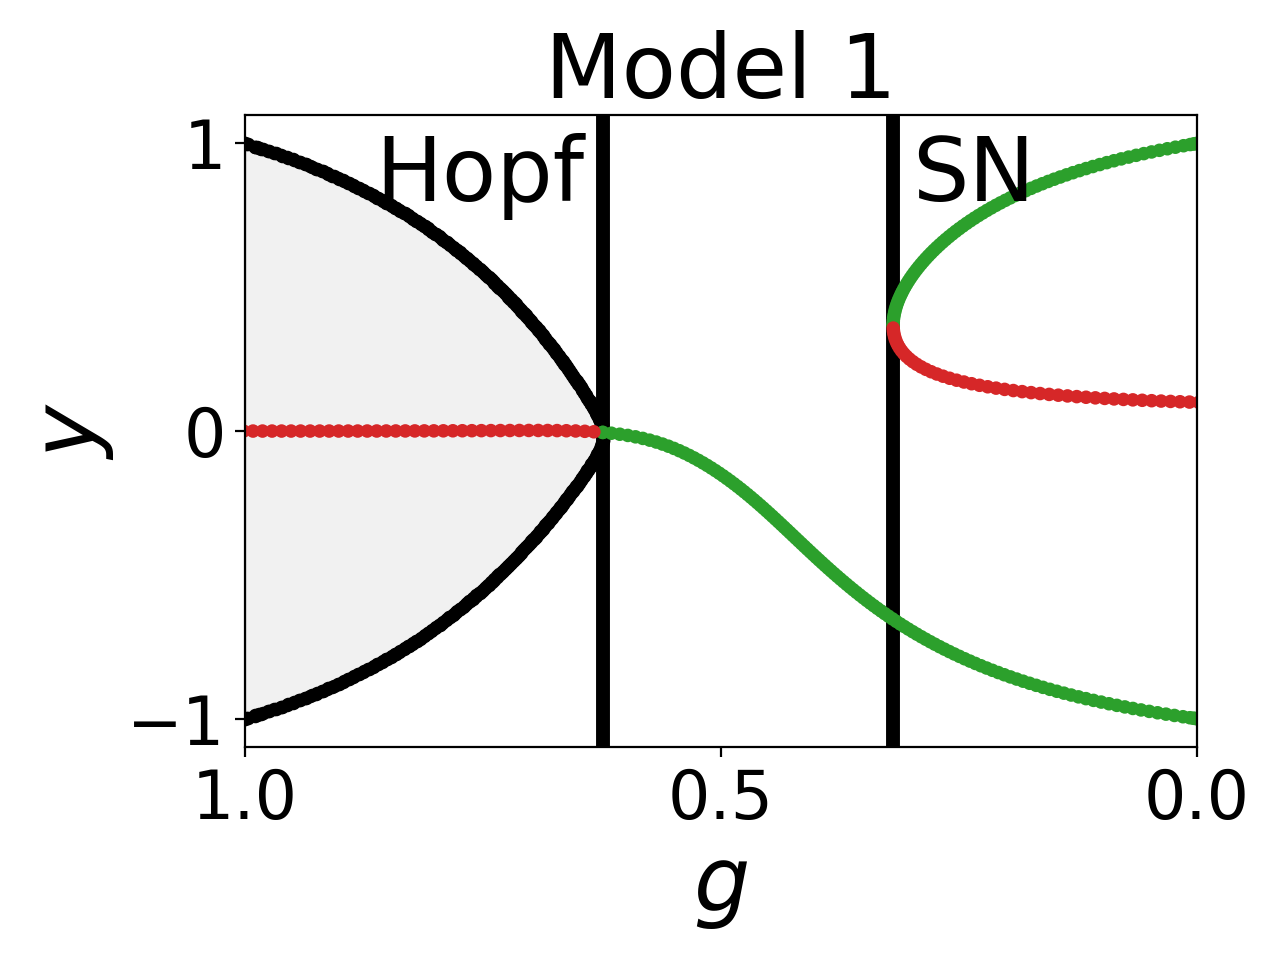

In [19]:
# 2D model with a Hopf bifurcation (Model 1)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_asym2_m1, fp_asym2_m1_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_asym2_m1_fp.dat')
lc_asym2_m1, lc_asym2_m1_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_asym2_m1_lc.dat')
g_Hopf = 0.624
g_SN = 0.319


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym2_m1[:110,3], lc_asym2_m1[:110,6], lc_asym2_m1[:110,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym2_m1[:,3], lc_asym2_m1[:,6], s=15, color='k')
ax.scatter(lc_asym2_m1[:,3], lc_asym2_m1[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_asym2_m1[:,3], fp_asym2_m1[:,6], s=15, color=fp_asym2_m1_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.8, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN, g_SN], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SN-0.02, 0.8, 'SN', fontsize=32, horizontalalignment='left')
    
# Plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-1., 0., 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


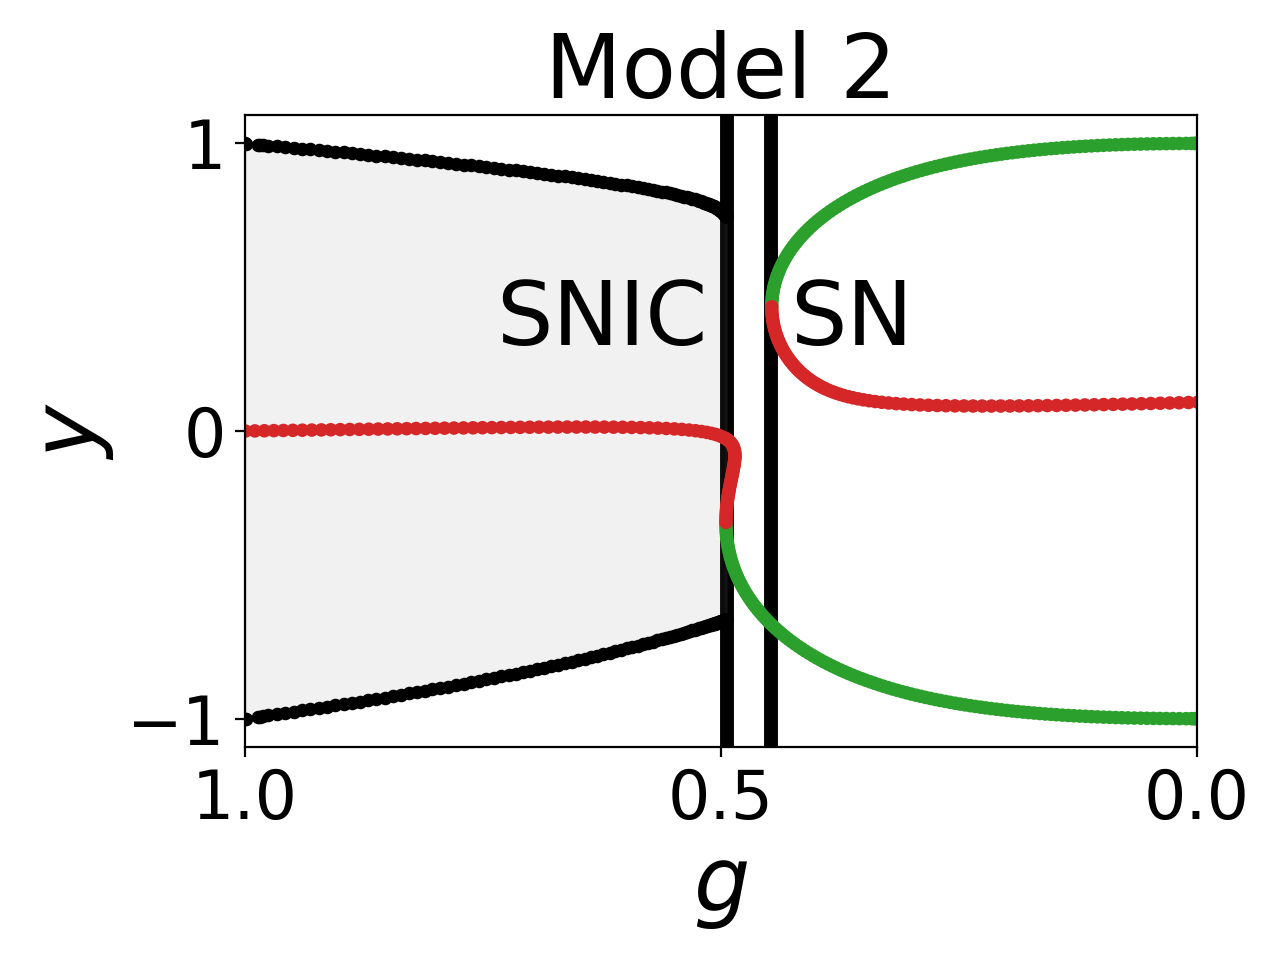

In [20]:
# 2D model with a SNIC bifurcation (Model 2)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_asym2_m2, fp_asym2_m2_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_asym2_m2_fp.dat')
lc_asym2_m2, lc_asym2_m2_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_asym2_m2_lc.dat')
g_SNIC = 0.494
g_SN = 0.447


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym2_m2[:,3], lc_asym2_m2[:,6], lc_asym2_m2[:,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym2_m2[:,3], lc_asym2_m2[:,6], s=15, color='k')
ax.scatter(lc_asym2_m2[:,3], lc_asym2_m2[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_asym2_m2[:,3], fp_asym2_m2[:,6], s=15, color=fp_asym2_m2_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.3, 'SNIC', fontsize=32, horizontalalignment='right')
ax.plot([g_SN, g_SN], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SN-0.02, 0.3, 'SN', fontsize=32, horizontalalignment='left')
    
# Plot options
ax.set_title('Model 2', fontsize=32) 
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-1., 0., 1.])
        
fig.tight_layout()
fig.show()

####    

**2.2.4 Fixed points outside the limit cycle**

We perform simulations with the stable fixed points of the static module at (-2, 0) and (2.5, 0), and the unstable fixed point at (0,0).

<IPython.core.display.Javascript object>


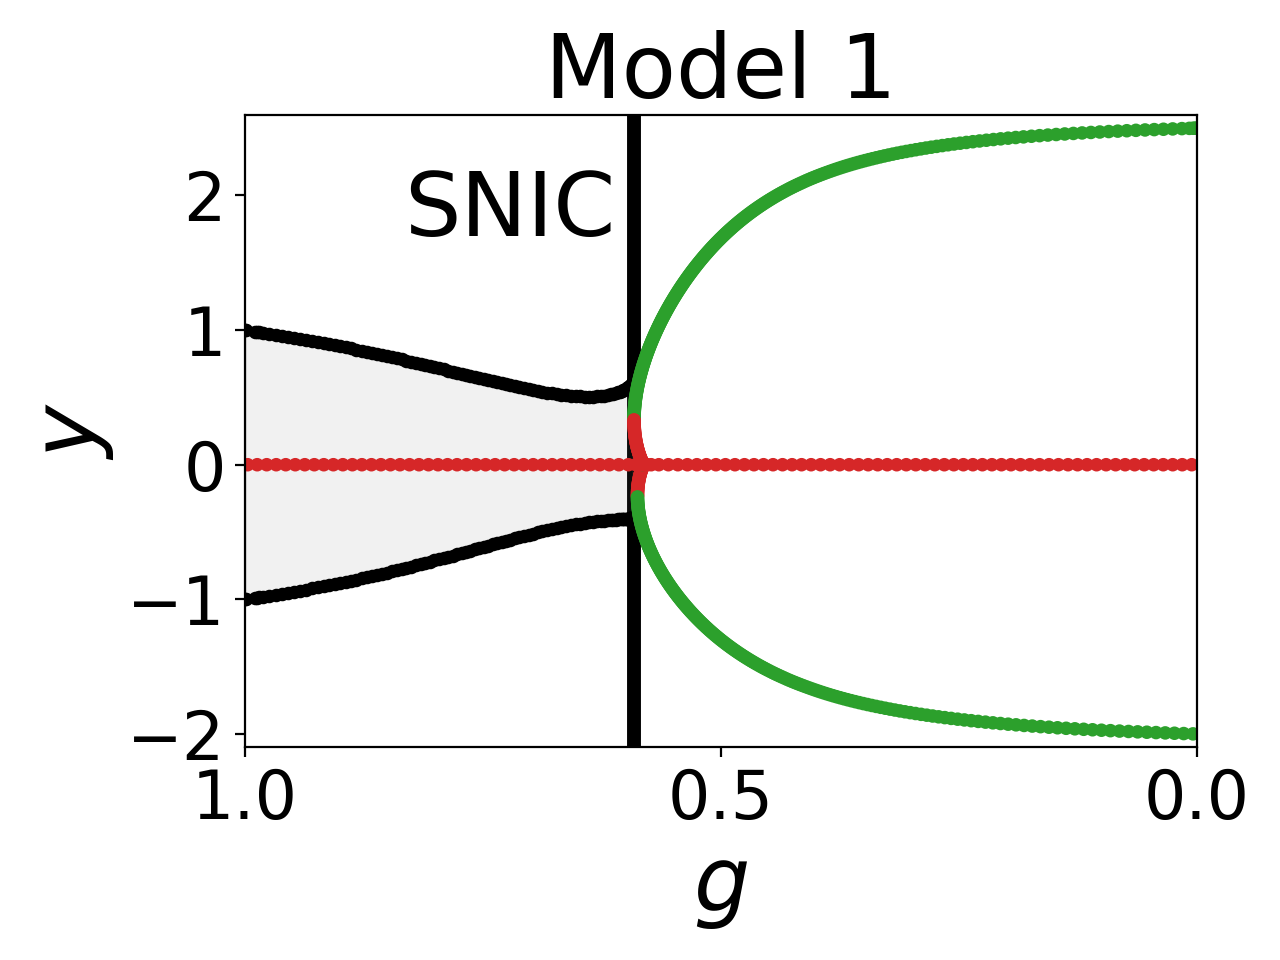

In [21]:
# 2D model with a Hopf bifurcation (Model 1)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_asym3_m1, fp_asym3_m1_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_asym3_m1_fp.dat')
lc_asym3_m1, lc_asym3_m1_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_asym3_m1_lc.dat')
g_SNIC = 0.591


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym3_m1[:110,3], lc_asym3_m1[:110,6], lc_asym3_m1[:110,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym3_m1[:,3], lc_asym3_m1[:,6], s=15, color='k')
ax.scatter(lc_asym3_m1[:,3], lc_asym3_m1[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_asym3_m1[:,3], fp_asym3_m1[:,6], s=15, color=fp_asym3_m1_color)

# Bifurcation
ax.plot([g_SNIC, g_SNIC], [-2.1, 2.6], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 1.7, 'SNIC', fontsize=32, horizontalalignment='right')
    
# Plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-2.1, 2.6])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-2, -1., 0., 1., 2.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


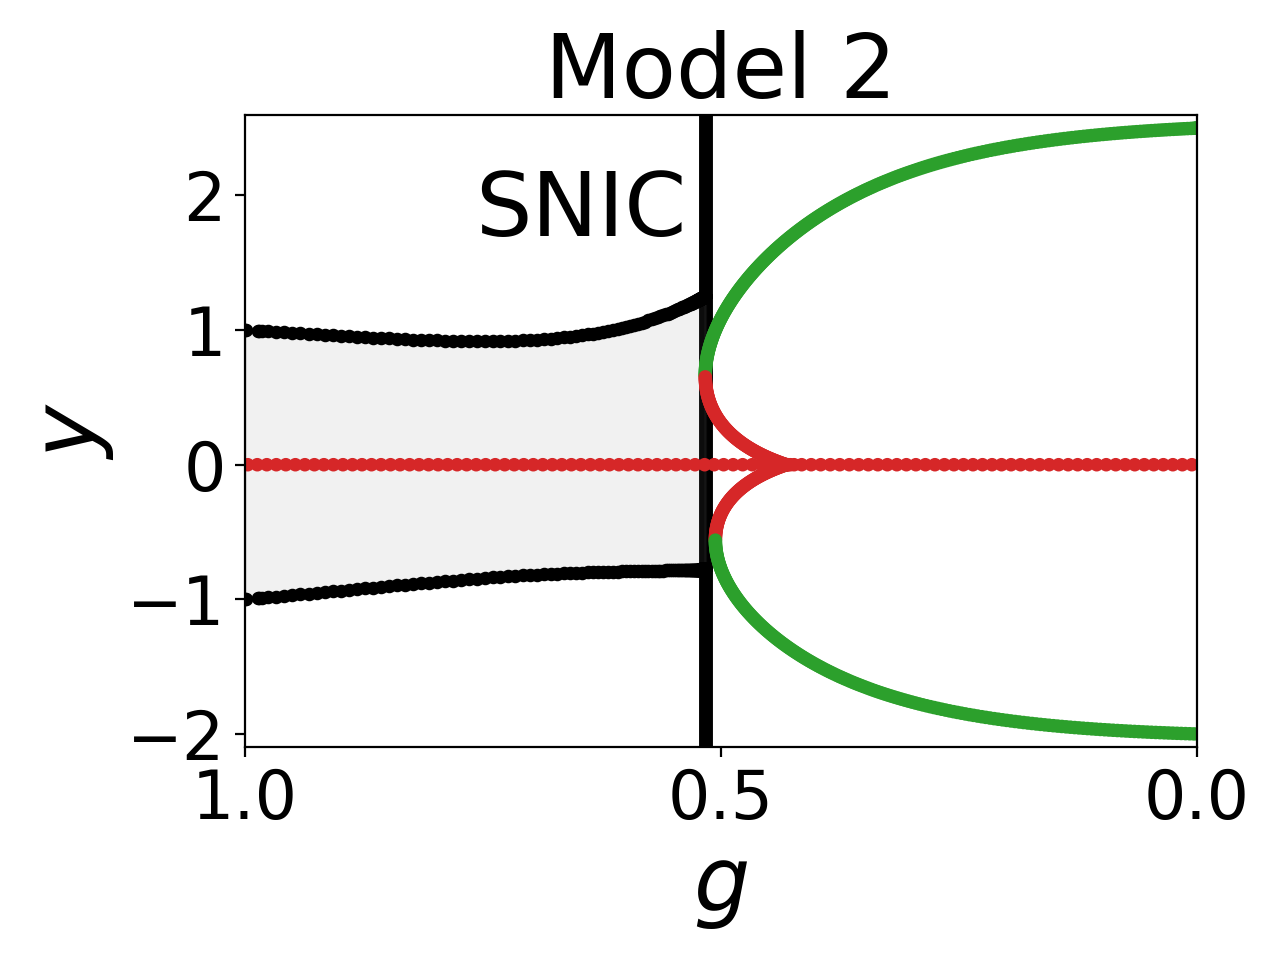

In [22]:
# 2D model with a SNIC bifurcation (Model 2)

# Extract the positions of the fixed points and limit cycles from the XPP AUTO data
fp_asym3_m2, fp_asym3_m2_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_asym3_m2_fp.dat')
lc_asym3_m2, lc_asym3_m2_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_asym3_m2_lc.dat')
g_SNIC = 0.516


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym3_m2[:,3], lc_asym3_m2[:,6], lc_asym3_m2[:,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym3_m2[:,3], lc_asym3_m2[:,6], s=15, color='k')
ax.scatter(lc_asym3_m2[:,3], lc_asym3_m2[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_asym3_m2[:,3], fp_asym3_m2[:,6], s=15, color=fp_asym3_m2_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-2.1, 2.6], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 1.7, 'SNIC', fontsize=32, horizontalalignment='right')
    
# Plot options
ax.set_title('Model 2', fontsize=32)  
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-2.1, 2.6])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([-2, -1., 0., 1., 2.])
        
fig.tight_layout()
fig.show()

####   

**3. Flow plots**

We plot the flow of the static term in the space of the $y$ and $z$ components. This allows us to visualise the positions of the stable fixed points (and compare it to the limit cycle of the dynamic module, which is on the unit circle).

On each flow plot, we represent the flow with thin black arrows. We also plot the $y$ and $z$ nullclines with orange and yellow lines, respectively. The $y$ (resp. $z$) nullcline is the solution to the equation obtained by setting the derivative of $y$ (resp. $z$) to 0. The fixed points of the system are found at the positions where the nullclines meet. We represent stable fixed points with green dots, and unstable fixed points with red dots.

####    

**3.1 Redefining the ODEs**

To get the flow and the nullclines, we use the `matplotlib` functions `streamplot` and `contour`. These functions require that we define the ODEs for the $y$ and $z$ components in separate functions.

In [23]:
def dy_static(y, param):
    
    fp0 = param["unstable_fp"]
    fp1 = param["stable_fp1"]
    fp2 = param["stable_fp2"]
        
    return (fp0-y)*(fp1-y)*(fp2-y)


def dz_static(z):
    
    return -z

####  

**3.2 Generating the flow plots**

We first create a grid of points at which we will determine the flow and the nullclines.

In [24]:
y_grid = np.arange(-1.7, 1.7, 0.01)
z_grid = np.arange(-1.7, 1.7, 0.01)
Y_grid, Z_grid = np.meshgrid(y_grid, z_grid)


y_grid2 = np.arange(-3.7, 3.7, 0.01)
z_grid2 = np.arange(-3.7, 3.7, 0.01)
Y_grid2, Z_grid2 = np.meshgrid(y_grid2, z_grid2)

####    

**3.2.1 Symmetric basins of attraction**

We generate the flow plot for the static module with stable fixed points at (-1, 0) and (1, 0), and an unstable fixed point at (0,0).

<IPython.core.display.Javascript object>


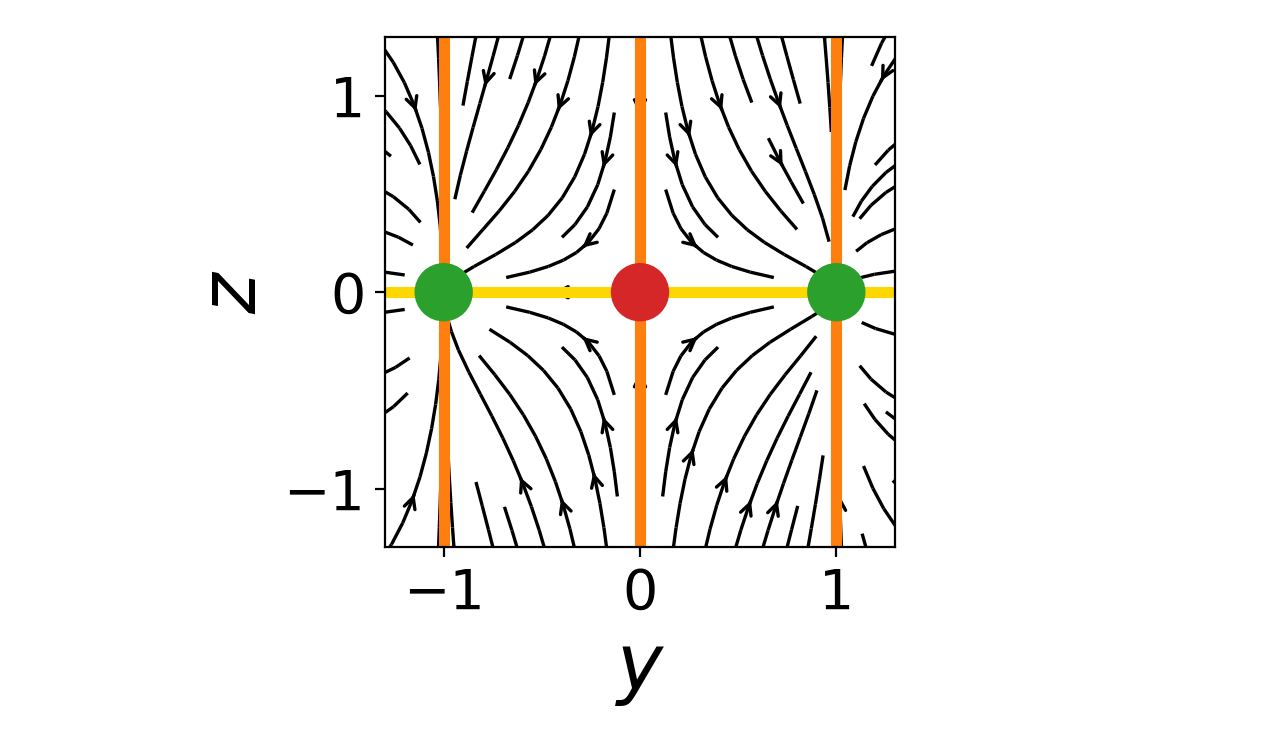

In [25]:
param["unstable_fp"] = 0.
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.


# Generate the flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()
    
# Flow
ax.streamplot(Y_grid, Z_grid, dy_static(Y_grid, param), dz_static(Z_grid), color='k', density=0.9, linewidth=1.2, arrowstyle='->', zorder=0)
    
# Nullclines
ax.contour(Y_grid, Z_grid, dy_static(Y_grid, param), levels=[0], colors='tab:orange', linewidths=4)
ax.contour(Y_grid, Z_grid, dz_static(Z_grid), levels=[0], colors='gold', linewidths=4)
        
# Fixed points
ax.scatter([-1.,0.,1.], [0.,0.,0.], color=['tab:green','tab:red','tab:green'], s=400, zorder=8)

# Plot options
ax.set_xlabel('$y$', fontsize=28)
ax.set_ylabel('$z$', fontsize=28)
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
ax.set_aspect('equal')
ax.tick_params(labelsize=20)

fig.tight_layout()
fig.show()

####    

**3.2.2 Slightly asymmetric basins of attraction**

We generate the flow plot for the static module with stable fixed points at (-1, 0) and (1, 0), and an unstable fixed point at (0.05,0).

<IPython.core.display.Javascript object>


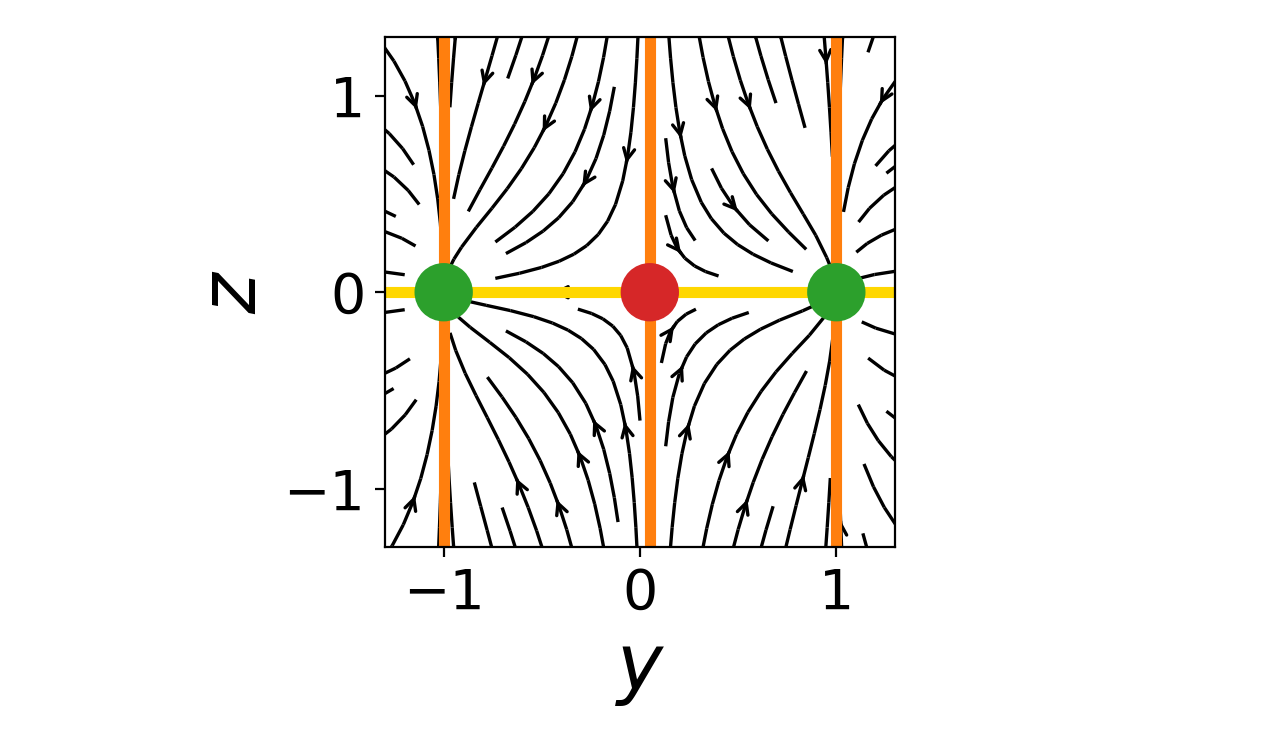

In [26]:
param["unstable_fp"] = 0.05
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.


# Generate the flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()
    
# Flow
ax.streamplot(Y_grid, Z_grid, dy_static(Y_grid, param), dz_static(Z_grid), color='k', density=0.9, linewidth=1.2, arrowstyle='->', zorder=0)
    
# Nullclines
ax.contour(Y_grid, Z_grid, dy_static(Y_grid, param), levels=[0], colors='tab:orange', linewidths=4)
ax.contour(Y_grid, Z_grid, dz_static(Z_grid), levels=[0], colors='gold', linewidths=4)
        
# Fixed points
ax.scatter([-1.,0.05,1.], [0.,0.,0.], color=['tab:green','tab:red','tab:green'], s=400, zorder=8)

# Plot options
ax.set_xlabel('$y$', fontsize=28)
ax.set_ylabel('$z$', fontsize=28)
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
ax.set_aspect('equal')
ax.tick_params(labelsize=20)

fig.tight_layout()
fig.show()

####    

**3.2.3 Asymmetric basins of attraction**

We generate the flow plot for the static module with stable fixed points at (-1, 0) and (1, 0), and an unstable fixed point at (0.1,0).

<IPython.core.display.Javascript object>


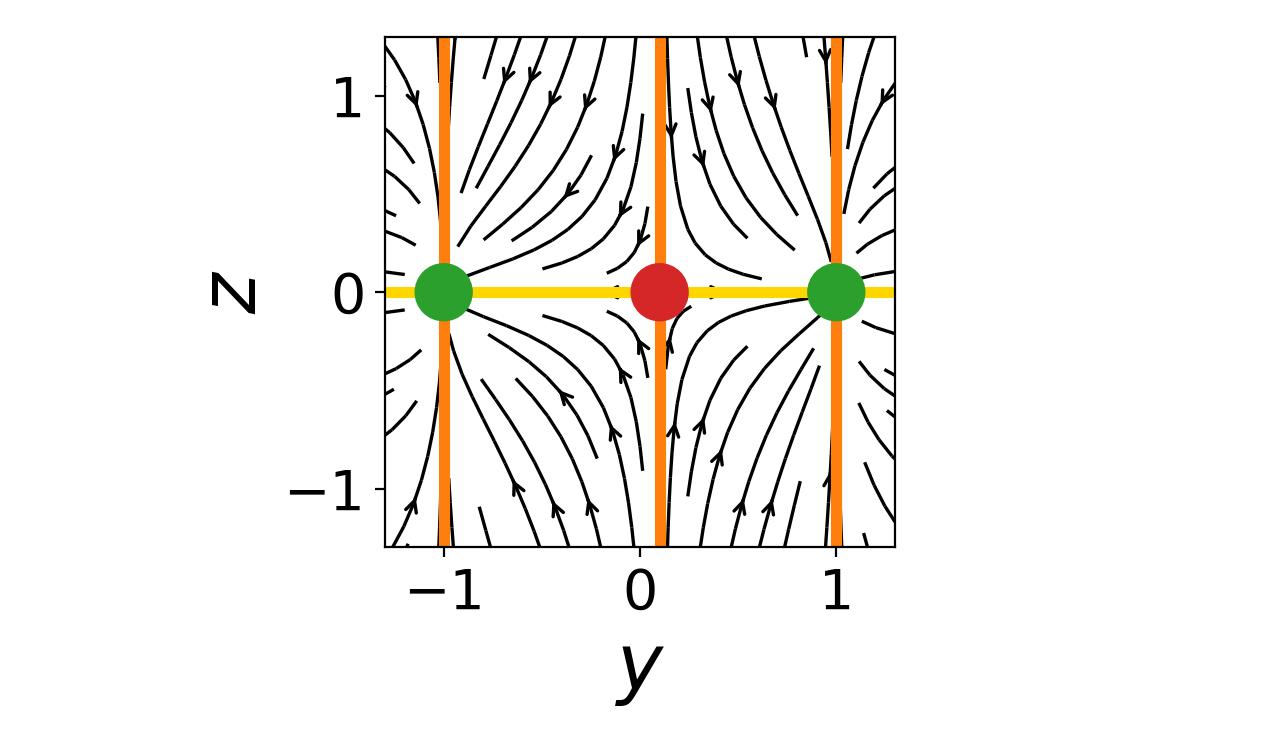

In [27]:
param["unstable_fp"] = 0.1
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.


# Generate the flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()
    
# Flow
ax.streamplot(Y_grid, Z_grid, dy_static(Y_grid, param), dz_static(Z_grid), color='k', density=0.9, linewidth=1.2, arrowstyle='->', zorder=0)
    
# Nullclines
ax.contour(Y_grid, Z_grid, dy_static(Y_grid, param), levels=[0], colors='tab:orange', linewidths=4)
ax.contour(Y_grid, Z_grid, dz_static(Z_grid), levels=[0], colors='gold', linewidths=4)
        
# Fixed points
ax.scatter([-1.,0.1,1.], [0.,0.,0.], color=['tab:green','tab:red','tab:green'], s=400, zorder=8)

# Plot options
ax.set_xlabel('$y$', fontsize=28)
ax.set_ylabel('$z$', fontsize=28)
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
ax.set_aspect('equal')
ax.tick_params(labelsize=20)

fig.tight_layout()
fig.show()

####    

**3.2.4 Fixed points outside the limit cycle**

We generate the flow plot for the static module with stable fixed points at (-2, 0) and (2.5, 0), and an unstable fixed point at (0,0).

<IPython.core.display.Javascript object>


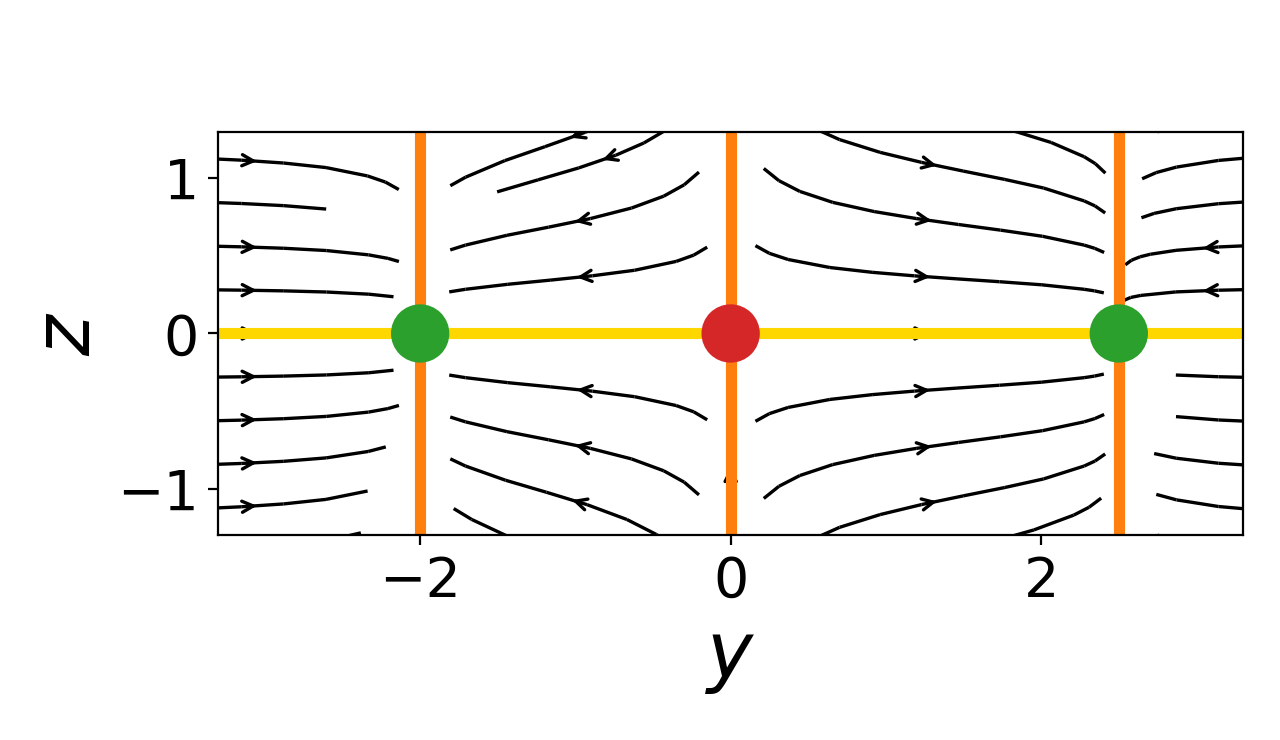

In [28]:
param["unstable_fp"] = 0.
param["stable_fp1"] = 2.5
param["stable_fp2"] = -2.


# Generate the flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()
    
# Flow
ax.streamplot(Y_grid2, Z_grid2, dy_static(Y_grid2, param), dz_static(Z_grid2), color='k', density=0.9, linewidth=1.2, arrowstyle='->', zorder=0)
    
# Nullclines
ax.contour(Y_grid2, Z_grid2, dy_static(Y_grid2, param), levels=[0], colors='tab:orange', linewidths=4)
ax.contour(Y_grid2, Z_grid2, dz_static(Z_grid2), levels=[0], colors='gold', linewidths=4)
        
# Fixed points
ax.scatter([-2.,0.,2.5], [0.,0.,0.], color=['tab:green','tab:red','tab:green'], s=400, zorder=8)

# Plot options
ax.set_xlabel('$y$', fontsize=28)
ax.set_ylabel('$z$', fontsize=28)
ax.set_xlim([-3.3, 3.3])
ax.set_ylim([-1.3, 1.3])
ax.set_aspect('equal')
ax.tick_params(labelsize=20)

fig.tight_layout()
fig.show()

####      

**4. Spatial wave profiles**

In this section, we plot the spatial wave profiles of the gene-free Models 1 and 2. We consider both symmetric and asymmetric basins of attraction for the fixed points of the static module.

In [29]:
param["s"] = 6.
param["v"] = 0.0042

param["total_t"] = 200.
param["n_steps_keep_results"] =30

####       
 
**4.1 Symmetric basins of attraction**

<IPython.core.display.Javascript object>


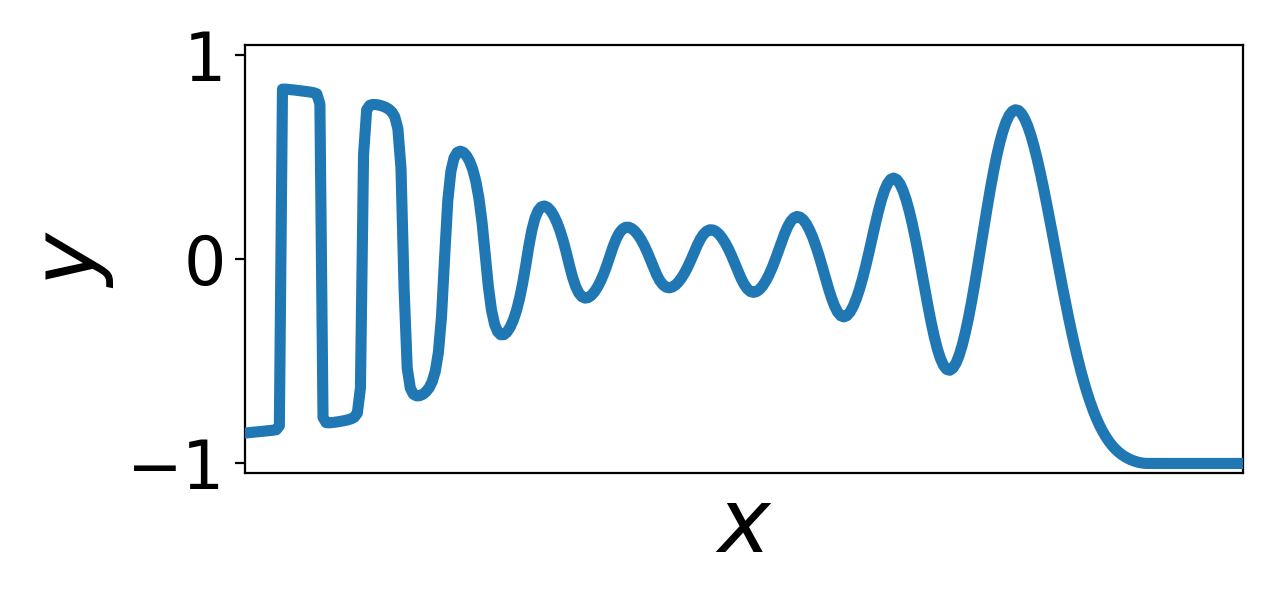

<IPython.core.display.Javascript object>


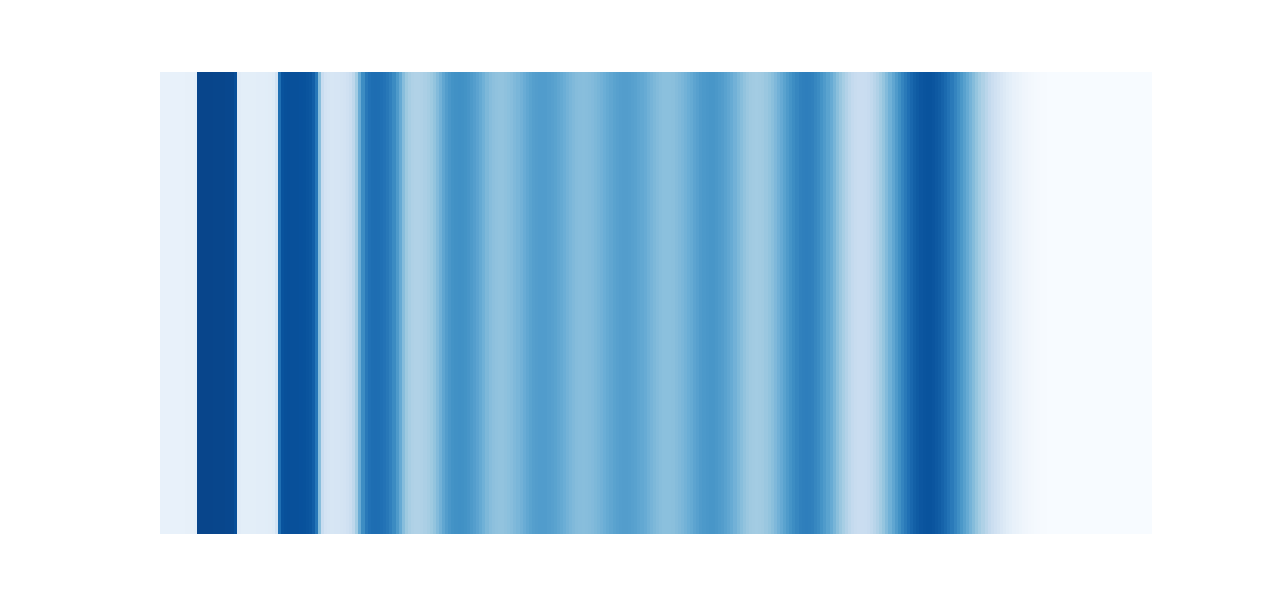

In [30]:
param["unstable_fp"] = 0.
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.

# Gene-free model with a Hopf bifurcation (Model 1)
param["if_interm"] = 1.
param["ng"] = 3

results2_sym_m1, g_gradient2_sym_m1, times_plot2_sym_m1 = integrate(init_vec, param)
plot_y_profile(results2_sym_m1, 492, 0.33, 0.65, param)

<IPython.core.display.Javascript object>


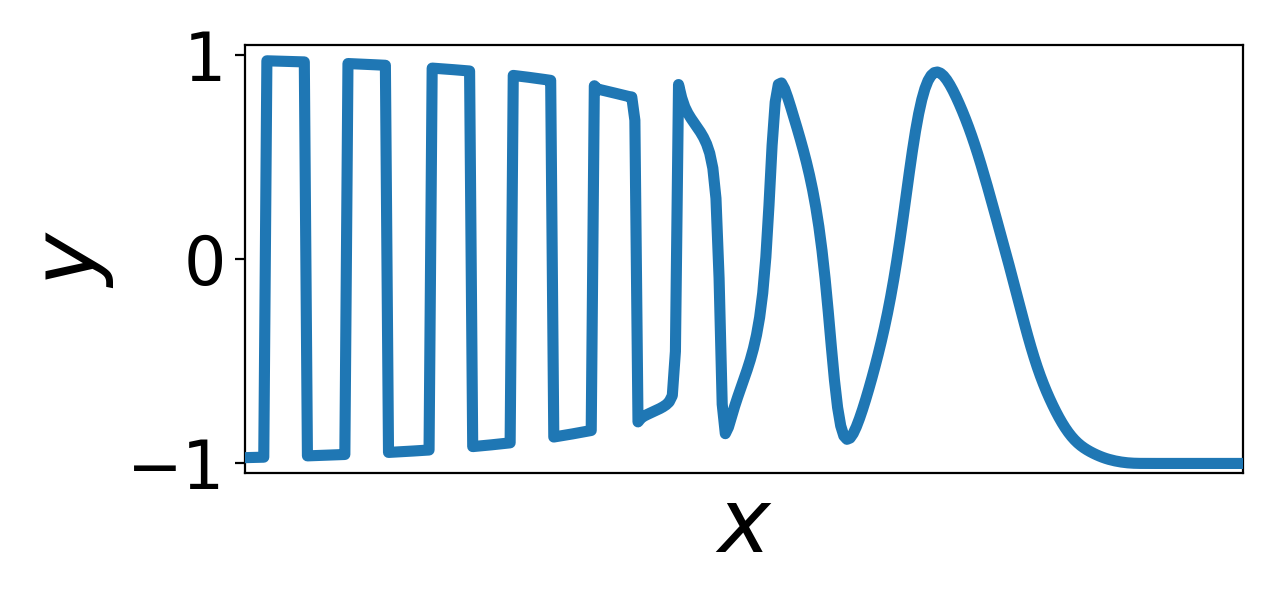

<IPython.core.display.Javascript object>


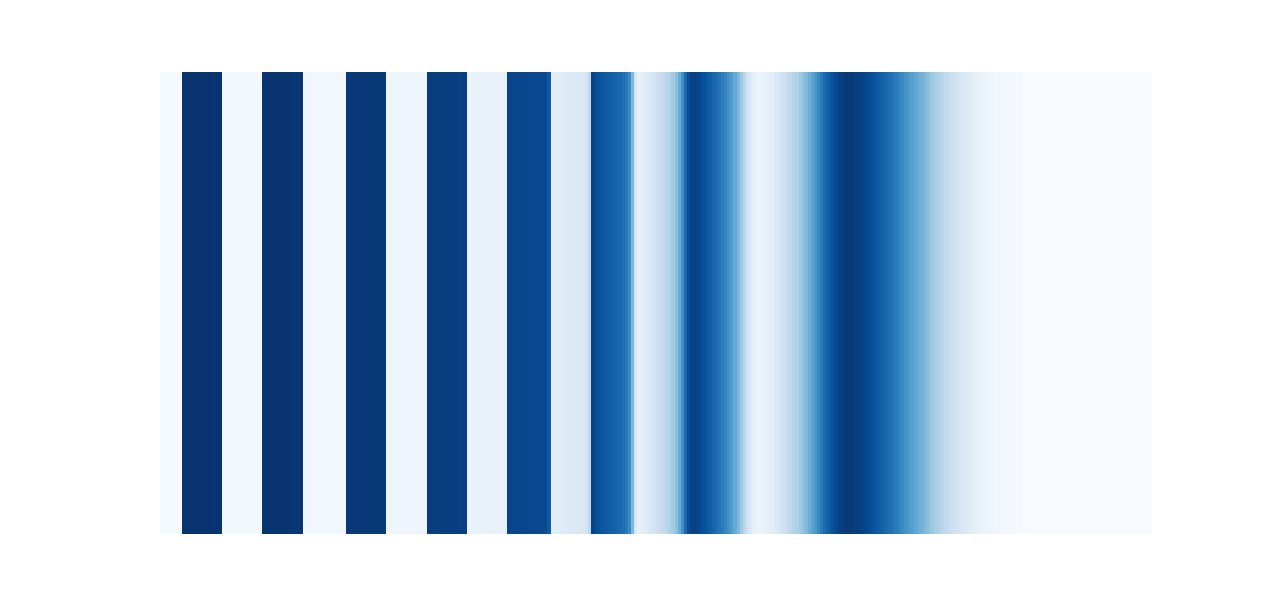

In [31]:
param["unstable_fp"] = 0.
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.

# Gene-free model with a SNIC bifurcation (Model 2)
param["if_interm"] = 0.
param["ng"] = 1

results2_sym_m2, g_gradient2_sym_m2, times_plot2_sym_m2 = integrate(init_vec, param)
plot_y_profile(results2_sym_m2, 492, 0.33, 0.65, param)

####    

**4.2 Asymmetric basins of attraction**

<IPython.core.display.Javascript object>


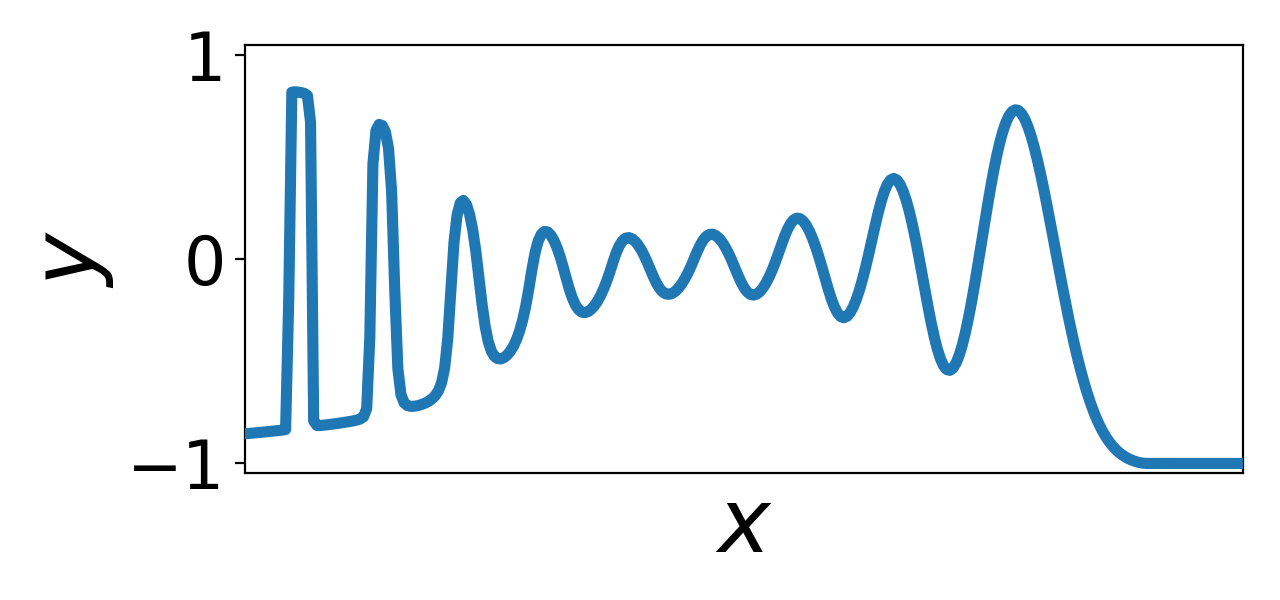

<IPython.core.display.Javascript object>


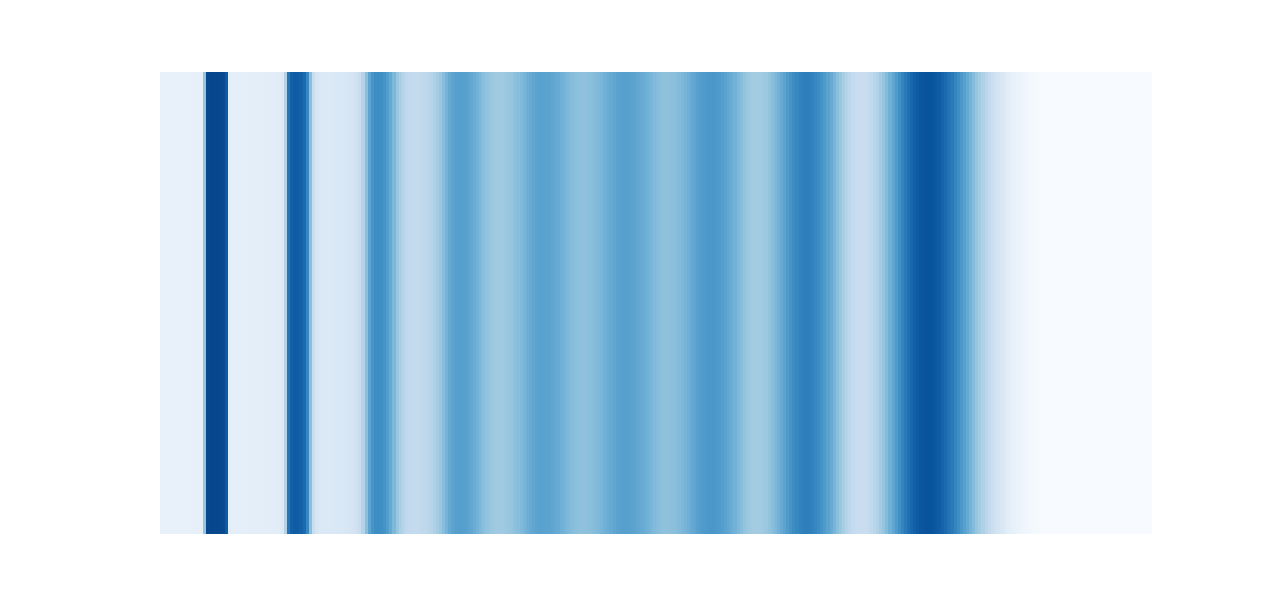

In [32]:
param["unstable_fp"] = 0.02
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.

# Gene-free model with a Hopf bifurcation (Model 1)
param["if_interm"] = 1.
param["ng"] = 3

results2_asym_m1, g_gradient2_asym_m1, times_plot2_asym_m1 = integrate(init_vec, param)
plot_y_profile(results2_asym_m1, 492, 0.33, 0.65, param)

<IPython.core.display.Javascript object>


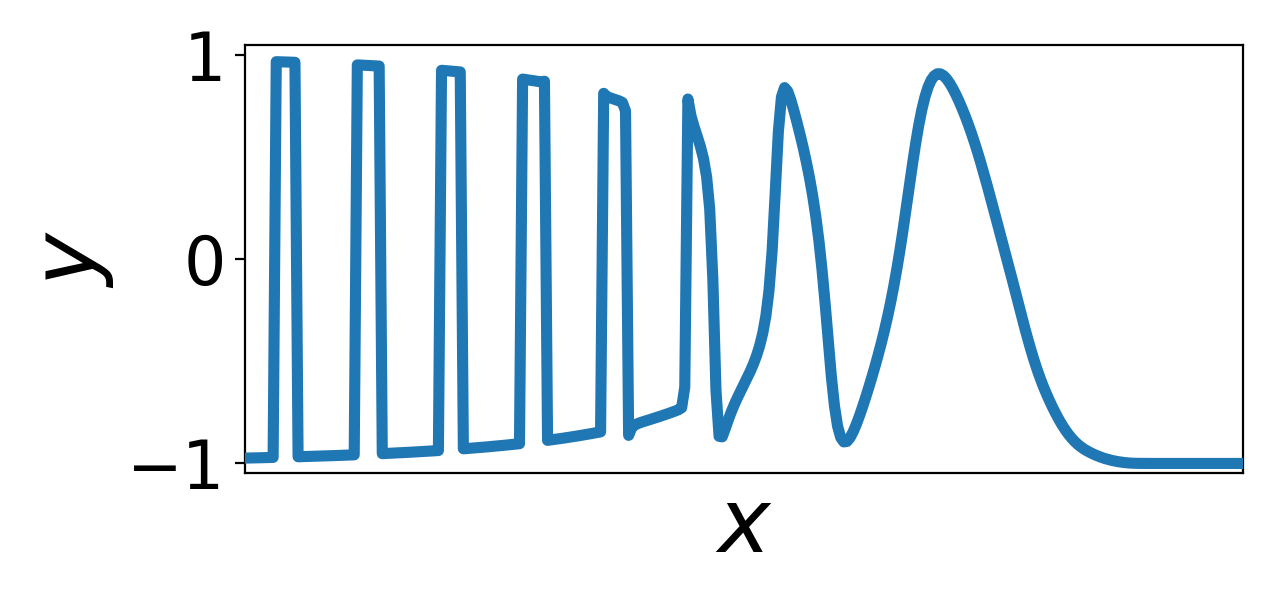

<IPython.core.display.Javascript object>


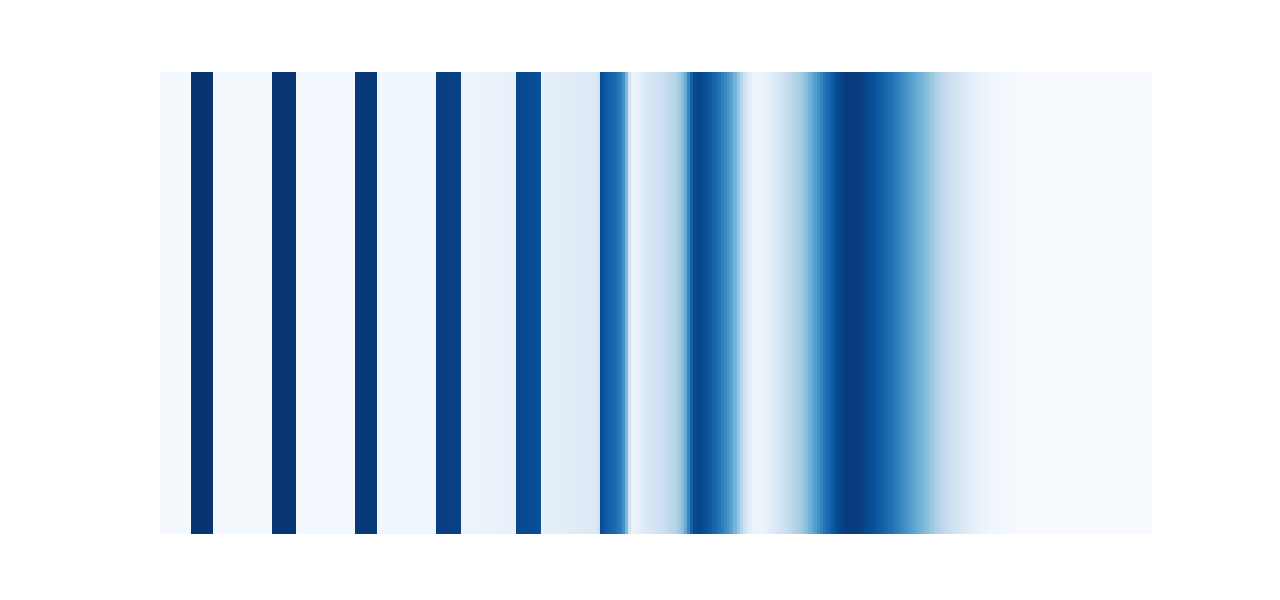

In [33]:
param["unstable_fp"] = 0.1
param["stable_fp1"] = 1.
param["stable_fp2"] = -1.
param["colorbar_max"] = 1.
param["colorbar_min"] = -1.

# Gene-free model with a SNIC bifurcation (Model 2)
param["if_interm"] = 0.
param["ng"] = 1

results2_asym_m2, g_gradient2_asym_m2, times_plot2_asym_m2 = integrate(init_vec, param)
plot_y_profile(results2_asym_m2, 492, 0.33, 0.65, param)